In [1]:
# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ 2-D GPU-accelerated point-vortex simulator in the unit disk             ║
# ║ ----------------------------------------------------------------------  ║
# ║ Param (2025-05-31)                                                       ║
# ╚══════════════════════════════════════════════════════════════════════════╝
#
# External deps (install once):
# !pip install cupy-cuda12x   # or cupy-cuda11x / cupy --no-binary :all:
# !pip install matplotlib tqdm

import math, sys, subprocess, warnings, pathlib, datetime
from pathlib import Path
import numpy as np

try:
    import cupy as xp                      # GPU backend
    _gpu = True
except (ImportError, RuntimeError):
    import numpy as xp                     # graceful CPU fallback
    _gpu = False
    warnings.warn("CuPy/CUDA not found – running on CPU (much slower)")

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
from matplotlib import cm
from tqdm import tqdm

# ----------------------------
# Simulation / physical params
# ----------------------------
N                = 25                               # number of vortices
Γ                = xp.asarray(np.random.choice([-1,1], size=N), dtype=xp.float32)  # circulations ±1
domain_R         = 1.0                              # unit disk
dt               = 1e-2                             # RK4 step
frames           = 1200                             # movie frames
steps_per_frame  = 4                                # → total steps = frames*spf
cmap             = cm.get_cmap("turbo")             # vivid perceptual gradient
dpi              = 200                              # movie resolution
outfile          = "vortex_simulation.mp4"

rng   = xp.random.default_rng(seed=0)
θ     = rng.uniform(0, 2*math.pi, N)
r     = xp.sqrt(rng.uniform(0, 0.9**2, N))          # start well inside the wall
x0    = xp.vstack([r*xp.cos(θ), r*xp.sin(θ)]).T     # (N,2)

# ----------------------------
# Helper – disk Green function
# ----------------------------
def grad_G_disk(x, y):
    """
    ∇_x G_D(x,y)  for the unit disk (eq. 2.6 in the paper)

    G_D(x,y) = (1/2π) ln |x - y| / |x - y*| |y|
    y* = y/|y|²
    """
    diff     = x - y                                      # (…,2)
    r2       = xp.sum(diff*diff, axis=-1, keepdims=True)  # scalar
    term1    = diff / r2                                  # ∇ ln|x-y|
    y_star   = y / xp.sum(y*y, axis=-1, keepdims=True)
    diff2    = x - y_star
    r2s      = xp.sum(diff2*diff2, axis=-1, keepdims=True)
    term2    = diff2 / r2s                                # ∇ ln|x-y*|
    return (term1 - term2) * (1/(2*math.pi))              # (…,2)

def grad_Robin_disk(x):
    """
    ∇_x γ_D(x,x)  where γ_D(x,x)=-(1/2π)ln(1-|x|²)
    """
    return  (1/(math.pi)) * x / (1 - xp.sum(x*x, axis=-1, keepdims=True))

# ----------------------------
# Vectorized velocity kernel
# ----------------------------
def velocity(x):
    """
    x : (N,2) current positions
    returns u : (N,2) velocity for each vortex
    """
    # Pairwise differences: broadcasting
    xi    = x[:, None, :]          # N,1,2
    xj    = x[None, :, :]          # 1,N,2
    mask  = xp.eye(N, dtype=bool)
    Dij   = grad_G_disk(xi, xj)    # N,N,2 (contains diag garbage but will mask)
    Dij[mask] = 0.0
    u     = xp.sum(Dij * Γ[None,:,None], axis=1)            # Biot–Savart sum
    # Add Robin term for each vortex (self-interaction & boundary)
    u    += 0.5 * Γ[:,None] * xp.flip(grad_Robin_disk(x), axis=-1) * xp.array([-1,1])
    return u

# ----------------------------
# Symplectic RK4 integrator
# ----------------------------
def rk4_step(x, h):
    k1 = velocity(x)
    k2 = velocity(x + 0.5*h*k1)
    k3 = velocity(x + 0.5*h*k2)
    k4 = velocity(x + h*k3)
    return x + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)

# ----------------------------
# Matplotlib figure setup
# ----------------------------
fig, ax = plt.subplots(figsize=(6,6), dpi=dpi, facecolor="black")
ax.set_aspect("equal"); ax.axis("off")
circle = plt.Circle((0,0), domain_R, edgecolor="w", facecolor="none", lw=1.5)
ax.add_patch(circle)
sc     = ax.scatter([], [], s=40, cmap=cmap, vmin=-1, vmax=1, edgecolors="none")

def init():
    sc.set_offsets(np.zeros((N,2)))
    sc.set_array(np.asarray(Γ.get() if _gpu else Γ))
    return sc,

def render(frame, pos_hist):
    pos = pos_hist[frame]
    sc.set_offsets(pos.get() if _gpu else pos)
    sc.set_array(np.asarray(Γ.get() if _gpu else Γ))
    return sc,

# ----------------------------
# Main time-integration loop
# ----------------------------
positions = xp.empty((frames, N, 2), dtype=xp.float32)
x         = x0.copy()

with tqdm(total=frames, desc="integrating") as pbar:
    for f in range(frames):
        for _ in range(steps_per_frame):
            x = rk4_step(x, dt)
        positions[f] = x
        pbar.update()

# ----------------------------
# Write MP4 & display inline
# ----------------------------
metadata = dict(title="Point-vortex dynamics in the unit disk",
                artist="Param / ChatGPT", comment=str(datetime.datetime.now()))
writer   = FFMpegWriter(fps=30, codec="libx264", bitrate=8000, metadata=metadata)

print("Encoding to", outfile)
with writer.saving(fig, outfile, dpi):
    for f in tqdm(range(frames), desc="encoding"):
        render(f, positions)
        writer.grab_frame(facecolor="black")

plt.close(fig)

# Preview (works in JupyterLab / VS Code)
from IPython.display import Video
Video(outfile, embed=True, width=600)

C:\Users\param\AppData\Local\Temp\ipykernel_83904\1966642712.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap             = cm.get_cmap("turbo")             # vivid perceptual gradient
C:\Users\param\AppData\Local\Temp\ipykernel_83904\1966642712.py:108: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  sc     = ax.scatter([], [], s=40, cmap=cmap, vmin=-1, vmax=1, edgecolors="none")
integrating: 100%|██████████| 1200/1200 [00:19<00:00, 60.11it/s]


Encoding to vortex_simulation.mp4


encoding: 100%|██████████| 1200/1200 [00:04<00:00, 241.53it/s]


In [9]:
import numpy as np
import cupy as cp
from cupyx.scipy.sparse import csc_matrix as cp_csc_matrix
from cupyx.scipy.sparse.linalg import cg as cp_cg
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
if not hasattr(cp, "scatter_add"):
    def _scatter_add(arr, idx_tuple, src):
        """Fallback using cp.add.at so existing calls keep working."""
        cp.add.at(arr, idx_tuple, src)
    cp.scatter_add = _scatter_add

import os
from scipy.interpolate import splprep, splev # For B-spline definition if needed, or implement manually

# --- Configuration ---
# Simulation parameters
DOMAIN_SIZE = (1.0, 2.0)  # Width, Height
GRID_RESOLUTION = (32, 64) # Nx, Ny cells
TIME_STEPS = 100
DT = 0.02
NUM_PARTICLES_PER_CELL = 40 # Average
FLIP_ALPHA = 0.97 # Blend between FLIP and PIC
GRAVITY = -0.0 # No gravity for this specific plume, buoyancy dominates
BUOYANCY_ALPHA = 5.0 # Strength of buoyancy
AMBIENT_TEMPERATURE = 0.0
MAX_CFL_VEL = 0.5 # Max velocity for CFL condition on DT

# B-spline degree (p=1 for linear B-splines, D^0 are piecewise constant)
P_DEGREE = 1

# Visualization
OUTPUT_FILENAME = "smoke_plume_coflip_simple.mp4"
FPS = 25

# --- Helper Functions & Classes ---

def get_bspline_coeffs_uniform_knots(degree, num_coeffs):
    """ Returns knots for B-splines of a given degree and number of coefficients """
    knots = np.zeros(num_coeffs + degree + 1)
    # Clamped knots for endpoint interpolation
    knots[degree + 1 : num_coeffs] = np.linspace(0, 1, num_coeffs - degree - 1)
    knots[num_coeffs:] = 1.0
    return cp.array(knots)

# For p=1, B^1_i(x) are linear hat functions, (B^1_i)'(x) are piecewise constant (+1/-1 scaled)
# D^0_i(x) are characteristic functions of intervals [knot_i, knot_{i+1}]

def evaluate_B1_basis(x_norm, i, knots_x):
    """ Evaluates i-th linear B-spline (B^1) at normalized coordinate x_norm.
        x_norm is cp.array of particle positions.
        i is the basis function index.
        knots_x are the knot vector cp.array.
    """
    # B^1_i(x) = (x - t_i)/(t_{i+1}-t_i) * B^0_i(x) + (t_{i+2}-x)/(t_{i+2}-t_{i+1}) * B^0_{i+1}(x)
    # Simplified: linear hat function centered at knots_x[i+1]
    # Support: [knots_x[i], knots_x[i+2]]
    
    val = cp.zeros_like(x_norm)
    
    # Rising part
    active1 = (x_norm >= knots_x[i]) & (x_norm < knots_x[i+1])
    denom1 = knots_x[i+1] - knots_x[i]
    if denom1 > 1e-6: # Avoid division by zero for coincident knots
        val = cp.where(active1, (x_norm - knots_x[i]) / denom1, val)

    # Falling part
    active2 = (x_norm >= knots_x[i+1]) & (x_norm < knots_x[i+2])
    denom2 = knots_x[i+2] - knots_x[i+1]
    if denom2 > 1e-6:
        val = cp.where(active2, (knots_x[i+2] - x_norm) / denom2, val)
        
    return val

def evaluate_D0_basis(x_norm, i, knots_x):
    """ Evaluates i-th D^0 basis (characteristic function for p=1)
        Support: [knots_x[i], knots_x[i+1]]
    """
    # D^0_i(x) is B^0_i(x) * p / (knots_x[i+p] - knots_x[i]). For p=1, D_i^0(x) = B_i^0(x) / (knots_x[i+1]-knots_x[i])
    # But paper's formula for I_k uses D^{p-1}. So D_i^{p-1} for p=1 is D_i^0.
    # The actual definition of D is a rescaled B-spline (Eq. 20).
    # For p=1, D_i^0(t) = (1 / (knots[i+1]-knots[i])) * B_i^0(t) if denom != 0, else 0
    # B_i^0(t) = 1 if t in [knots[i], knots[i+1]), else 0.
    # So D_i^0 is 1/(knot_width) on its interval.
    # For simplicity in forming MAC grid like structures, let's assume D_i^0 means it's associated with cell i.
    # Its value is 1 within cell i, 0 otherwise.
    val = cp.zeros_like(x_norm)
    active = (x_norm >= knots_x[i]) & (x_norm < knots_x[i+1])
    val = cp.where(active, 1.0, val) # Simplified: a boxcar for the cell/interval
    return val


class SmokePlumeCOFLIP:
    def __init__(self):
        self.domain_size = DOMAIN_SIZE
        self.grid_res = GRID_RESOLUTION
        self.dx = DOMAIN_SIZE[0] / GRID_RESOLUTION[0]
        self.dy = DOMAIN_SIZE[1] / GRID_RESOLUTION[1]
        self.dt = DT

        self.Nx, self.Ny = GRID_RESOLUTION
        
        # MAC grid velocities (num_faces_x, num_faces_y)
        # u: (Nx+1, Ny), v: (Nx, Ny+1)
        self.u_grid = cp.zeros((self.Nx + 1, self.Ny))
        self.v_grid = cp.zeros((self.Nx, self.Ny + 1))
        self.u_weights = cp.zeros_like(self.u_grid) # For P2G
        self.v_weights = cp.zeros_like(self.v_grid) # For P2G
        
        # Pressure (cell-centered)
        self.pressure = cp.zeros((self.Nx, self.Ny))
        
        # Streamfunction (node-centered)
        self.psi = cp.zeros((self.Nx + 1, self.Ny + 1))

        # Cell types (0: fluid, 1: solid - not used here beyond boundary)
        self.cell_type = cp.zeros((self.Nx, self.Ny), dtype=cp.int32)
        
        # Particle data
        self.num_particles = self.Nx * self.Ny * NUM_PARTICLES_PER_CELL
        self.px = cp.random.uniform(0, DOMAIN_SIZE[0], self.num_particles).astype(cp.float32)
        self.py = cp.random.uniform(0, DOMAIN_SIZE[1], self.num_particles).astype(cp.float32)
        
        # Particle "impulses" (covectors, same dimension as velocity for Euclidean)
        self.pu = cp.zeros(self.num_particles, dtype=cp.float32)
        self.pv = cp.zeros(self.num_particles, dtype=cp.float32)

        # Particle smoke density / temperature
        self.p_smoke = cp.zeros(self.num_particles, dtype=cp.float32)
        self.p_temp = cp.full(self.num_particles, AMBIENT_TEMPERATURE, dtype=cp.float32)

        # Initialize smoke source
        source_center_x, source_center_y = DOMAIN_SIZE[0] * 0.5, self.dy * 3
        source_radius = DOMAIN_SIZE[0] * 0.1
        dist_sq = (self.px - source_center_x)**2 + (self.py - source_center_y)**2
        source_mask = dist_sq < source_radius**2
        self.p_smoke = cp.where(source_mask, 1.0, self.p_smoke)
        self.p_temp = cp.where(source_mask, 1.0, self.p_temp) # Hot source
        self.pv = cp.where(source_mask, 0.5, self.pv) # Initial upward kick

        # B-spline knot vectors (uniform, clamped)
        # For p=1, num_coeffs_x = Nx+1 (for nodes)
        # num_basis_B1_x = Nx+1, num_basis_D0_x = Nx
        self.knots_x_B1 = get_bspline_coeffs_uniform_knots(P_DEGREE, self.Nx + 1)
        self.knots_y_B1 = get_bspline_coeffs_uniform_knots(P_DEGREE, self.Ny + 1)
        self.knots_x_D0 = get_bspline_coeffs_uniform_knots(P_DEGREE-1, self.Nx) # knots for cells / D0
        self.knots_y_D0 = get_bspline_coeffs_uniform_knots(P_DEGREE-1, self.Ny)
        
        # Visualization grid
        self.vis_res_x, self.vis_res_y = 128, 256
        self.vis_grid_smoke = cp.zeros((self.vis_res_x, self.vis_res_y))
        
        # Colormap
        colors = [(0.01,0.01,0.15), (0.1,0.3,0.5), (0.4,0.7,0.8), (0.9,0.9,0.7)] # DarkBlue, MedBlue, LightCyan, PaleYellow
        nodes = [0.0, 0.3, 0.65, 1.0]
        self.smoke_cmap = LinearSegmentedColormap.from_list("smoke_plume", list(zip(nodes, colors)))
        self.smoke_cmap.set_under(colors[0])


    def _get_normalized_coords(self, x_world, y_world):
        # Particles coords to [0,1] range for B-spline eval
        x_norm = x_world / self.domain_size[0]
        y_norm = y_world / self.domain_size[1]
        return x_norm, y_norm

    def _g2p_interpolate_field(self, field_coeffs_u, field_coeffs_v, px_norm, py_norm):
        # Interpolate grid velocity to particles using p=1 B-splines
        # This is a simplified G2P, not fully mimetic I_1 from paper but APIC/FLIP like for p=1
        # For I_1 with p=1: u from D0_x B1_y, v from B1_x D0_y
        
        # Simplest: Bilinear interpolation from MAC grid (equivalent to p=1 tensor product B-splines for values at certain points)
        val_u = cp.zeros_like(px_norm)
        val_v = cp.zeros_like(py_norm)

        # u-velocity (centers of vertical faces)
        gx_u = px_norm * self.Nx # Convert to grid cell space for u
        gy_u = py_norm * self.Ny - 0.5
        
        ix_u = cp.floor(gx_u).astype(cp.int32)
        iy_u = cp.floor(gy_u).astype(cp.int32)
        fx_u = gx_u - ix_u
        fy_u = gy_u - iy_u

        ix_u = cp.clip(ix_u, 0, self.Nx -1) # u_grid is (Nx+1, Ny), so indices for coeffs are 0..Nx
        iy_u = cp.clip(iy_u, 0, self.Ny -1)
        
        # u_grid indices: (ix_u corresponds to left face, ix_u+1 to right face of a cell center for pressure)
        # Here, it's slightly different. px is world coord.
        # For u at (i+0.5)dx, j dy:
        px_u_grid = self.px / self.dx
        py_u_grid = self.py / self.dy - 0.5 # Relative to u-nodes
        
        i0_u = cp.floor(px_u_grid).astype(cp.int32)
        j0_u = cp.floor(py_u_grid).astype(cp.int32)
        wx_u = px_u_grid - i0_u
        wy_u = py_u_grid - j0_u
        
        i0_u = cp.clip(i0_u, 0, self.Nx); i1_u = cp.clip(i0_u + 1, 0, self.Nx)
        j0_u = cp.clip(j0_u, 0, self.Ny - 1); j1_u = cp.clip(j0_u + 1, 0, self.Ny - 1)

        n00_u = field_coeffs_u[i0_u, j0_u] * (1-wx_u) + field_coeffs_u[i1_u, j0_u] * wx_u
        n10_u = field_coeffs_u[i0_u, j1_u] * (1-wx_u) + field_coeffs_u[i1_u, j1_u] * wx_u
        val_u = n00_u * (1-wy_u) + n10_u * wy_u
        
        # v-velocity (centers of horizontal faces)
        px_v_grid = self.px / self.dx - 0.5 # Relative to v-nodes
        py_v_grid = self.py / self.dy

        i0_v = cp.floor(px_v_grid).astype(cp.int32)
        j0_v = cp.floor(py_v_grid).astype(cp.int32)
        wx_v = px_v_grid - i0_v
        wy_v = py_v_grid - j0_v

        i0_v = cp.clip(i0_v, 0, self.Nx - 1); i1_v = cp.clip(i0_v + 1, 0, self.Nx - 1)
        j0_v = cp.clip(j0_v, 0, self.Ny); j1_v = cp.clip(j0_v + 1, 0, self.Ny)
        
        n00_v = field_coeffs_v[i0_v, j0_v] * (1-wy_v) + field_coeffs_v[i0_v, j1_v] * wy_v
        n10_v = field_coeffs_v[i1_v, j0_v] * (1-wy_v) + field_coeffs_v[i1_v, j1_v] * wy_v
        val_v = n00_v * (1-wx_v) + n10_v * wx_v
        
        return val_u, val_v

    def _p2g_transfer(self):
        # P2G: Particle to Grid (Quadratic B-spline like weights, or p=1 for APIC style)
        # Simplified: use linear APIC-style interpolation (summing weighted particle values)
        # This should be the pseudo-inverse I^+ (least squares solve)
        # For now, standard PIC/FLIP weighted sum as a placeholder for I_1 basis functions

        self.u_grid.fill(0); self.v_grid.fill(0)
        self.u_weights.fill(1e-9); self.v_weights.fill(1e-9) # Avoid div by zero

        # For u-grid (vertical faces)
        px_u_rel = self.px / self.dx # Particle x pos relative to grid lines
        py_u_rel = self.py / self.dy - 0.5 # Particle y pos relative to u-node grid lines
        
        iu0 = cp.floor(px_u_rel).astype(cp.int32)
        ju0 = cp.floor(py_u_rel).astype(cp.int32)
        
        wx_u1 = px_u_rel - iu0; wx_u0 = 1.0 - wx_u1
        wy_u1 = py_u_rel - ju0; wy_u0 = 1.0 - wy_u1

        # Scatter to 4 u-nodes
        # Node (iu0, ju0)
        idx_u_x = cp.clip(iu0,   0, self.Nx)
        idx_u_y = cp.clip(ju0,   0, self.Ny-1)
        w = wx_u0 * wy_u0
        cp.scatter_add(self.u_grid, (idx_u_x, idx_u_y), w * self.pu)
        cp.scatter_add(self.u_weights, (idx_u_x, idx_u_y), w)
        
        # Node (iu0+1, ju0)
        idx_u_x = cp.clip(iu0+1, 0, self.Nx)
        idx_u_y = cp.clip(ju0,   0, self.Ny-1)
        w = wx_u1 * wy_u0
        cp.scatter_add(self.u_grid, (idx_u_x, idx_u_y), w * self.pu)
        cp.scatter_add(self.u_weights, (idx_u_x, idx_u_y), w)

        # Node (iu0, ju0+1)
        idx_u_x = cp.clip(iu0,   0, self.Nx)
        idx_u_y = cp.clip(ju0+1, 0, self.Ny-1)
        w = wx_u0 * wy_u1
        cp.scatter_add(self.u_grid, (idx_u_x, idx_u_y), w * self.pu)
        cp.scatter_add(self.u_weights, (idx_u_x, idx_u_y), w)
        
        # Node (iu0+1, ju0+1)
        idx_u_x = cp.clip(iu0+1, 0, self.Nx)
        idx_u_y = cp.clip(ju0+1, 0, self.Ny-1)
        w = wx_u1 * wy_u1
        cp.scatter_add(self.u_grid, (idx_u_x, idx_u_y), w * self.pu)
        cp.scatter_add(self.u_weights, (idx_u_x, idx_u_y), w)

        self.u_grid /= self.u_weights

        # For v-grid (horizontal faces)
        px_v_rel = self.px / self.dx - 0.5
        py_v_rel = self.py / self.dy
        
        iv0 = cp.floor(px_v_rel).astype(cp.int32)
        jv0 = cp.floor(py_v_rel).astype(cp.int32)

        wx_v1 = px_v_rel - iv0; wx_v0 = 1.0 - wx_v1
        wy_v1 = py_v_rel - jv0; wy_v0 = 1.0 - wy_v1

        # Scatter to 4 v-nodes
        idx_v_x = cp.clip(iv0,   0, self.Nx-1)
        idx_v_y = cp.clip(jv0,   0, self.Ny)
        w = wx_v0 * wy_v0
        cp.scatter_add(self.v_grid, (idx_v_x, idx_v_y), w * self.pv)
        cp.scatter_add(self.v_weights, (idx_v_x, idx_v_y), w)
        
        idx_v_x = cp.clip(iv0+1, 0, self.Nx-1)
        idx_v_y = cp.clip(jv0,   0, self.Ny)
        w = wx_v1 * wy_v0
        cp.scatter_add(self.v_grid, (idx_v_x, idx_v_y), w * self.pv)
        cp.scatter_add(self.v_weights, (idx_v_x, idx_v_y), w)

        idx_v_x = cp.clip(iv0,   0, self.Nx-1)
        idx_v_y = cp.clip(jv0+1, 0, self.Ny)
        w = wx_v0 * wy_v1
        cp.scatter_add(self.v_grid, (idx_v_x, idx_v_y), w * self.pv)
        cp.scatter_add(self.v_weights, (idx_v_x, idx_v_y), w)
        
        idx_v_x = cp.clip(iv0+1, 0, self.Nx-1)
        idx_v_y = cp.clip(jv0+1, 0, self.Ny)
        w = wx_v1 * wy_v1
        cp.scatter_add(self.v_grid, (idx_v_x, idx_v_y), w * self.pv)
        cp.scatter_add(self.v_weights, (idx_v_x, idx_v_y), w)
        
        self.v_grid /= self.v_weights
        
        # A true I^+ P2G would involve constructing the basis evaluation matrix S
        # and solving (S^T W S) f = S^T W u_p.
        # For B-splines, this matrix S would use evaluate_B1_basis and evaluate_D0_basis.
        # The matrix (S^T W S) would be related to the mass matrix star_1.
        pass


    def _apply_buoyancy(self):
        # Simplified buoyancy: transfer particle temp to grid, add force
        grid_temp = cp.zeros((self.Nx, self.Ny))
        grid_temp_weights = cp.zeros_like(grid_temp) + 1e-9

        # P2G for temperature (cell centers)
        px_c_rel = self.px / self.dx - 0.5
        py_c_rel = self.py / self.dy - 0.5
        
        ic0 = cp.floor(px_c_rel).astype(cp.int32)
        jc0 = cp.floor(py_c_rel).astype(cp.int32)

        wx_c1 = px_c_rel - ic0; wx_c0 = 1.0 - wx_c1
        wy_c1 = py_c_rel - jc0; wy_c0 = 1.0 - wy_c1
        
        # Scatter to 4 cell centers (bilinear weights)
        for i_offset, wx_eff in zip([0, 1, 0, 1], [wx_c0, wx_c1, wx_c0, wx_c1]):
            for j_offset, wy_eff in zip([0, 0, 1, 1], [wy_c0, wy_c0, wy_c1, wy_c1]):
                idx_c_x = cp.clip(ic0 + i_offset, 0, self.Nx-1)
                idx_c_y = cp.clip(jc0 + j_offset, 0, self.Ny-1)
                w = wx_eff * wy_eff # This is incorrect for bilinear, should be (1-wx)(1-wy) etc.
                                     # Corrected scatter for bilinear:
        # Corrected bilinear scatter:
        x_indices = [cp.clip(ic0,0,self.Nx-1), cp.clip(ic0+1,0,self.Nx-1), 
                     cp.clip(ic0,0,self.Nx-1), cp.clip(ic0+1,0,self.Nx-1)]
        y_indices = [cp.clip(jc0,0,self.Ny-1), cp.clip(jc0,0,self.Ny-1), 
                     cp.clip(jc0+1,0,self.Ny-1), cp.clip(jc0+1,0,self.Ny-1)]
        weights   = [wx_c0*wy_c0, wx_c1*wy_c0, wx_c0*wy_c1, wx_c1*wy_c1]

        for i in range(4):
            cp.scatter_add(grid_temp, (x_indices[i], y_indices[i]), weights[i] * self.p_temp)
            cp.scatter_add(grid_temp_weights, (x_indices[i], y_indices[i]), weights[i])
        
        grid_temp /= grid_temp_weights
        
        # Add buoyancy force to v_grid (vertical velocity component)
        # Force acts at cell centers, average to v-face locations
        buoyancy_force_y = BUOYANCY_ALPHA * (grid_temp - AMBIENT_TEMPERATURE) # * (-GRAVITY_Y if used)
        
        # Average to v_grid locations (horizontal faces)
        # v_grid[i,j] is at (i+0.5)dx, j dy
        # buoyancy_force_y[i,j] is at (i+0.5)dx, (j+0.5)dy
        # So for v_grid[i,j], average buoyancy_force_y[i, j-1] and buoyancy_force_y[i,j]
        
        v_buoy_contrib = cp.zeros_like(self.v_grid)
        v_buoy_contrib[:, 1:self.Ny] = 0.5 * (buoyancy_force_y[:, 0:self.Ny-1] + buoyancy_force_y[:, 1:self.Ny])
        # Handle boundaries for v_grid[i,0] and v_grid[i,Ny]
        v_buoy_contrib[:, 0] = buoyancy_force_y[:,0] # Or extrapolate
        v_buoy_contrib[:, self.Ny] = buoyancy_force_y[:, self.Ny-1]
        
        self.v_grid += self.dt * v_buoy_contrib


    def _project_divergence_free(self):
        # Pressure projection to enforce divergence-free condition
        # Solve L psi = div(u) where L is Laplacian for psi (node centered)
        # Then u = u - grad(psi_transformed_to_pressure_on_cells) OR u_new = curl(psi)
        # Paper: P_Bdiv f = f - star_1^-1 d_0^T (d_0 star_1^-1 d_0^T)^-1 d_0 f (Eq 9)
        # Or streamfunction: (d_0^T star_1 d_0) psi = d_0^T star_1 f_raw (Eq 34a for 2D)
        # Then f_new = d_0 psi (Eq 34b)
        # Here f_raw = (u_grid, v_grid). d_0^T star_1 f_raw is like weighted divergence.
        # (d_0^T star_1 d_0) is a Laplacian on psi.
        # For p=1 B-splines, star_1 components are integrals like int D0 B1 D0 B1 and int B1 D0 B1 D0
        # d0 maps nodes to edges. d0^T maps edges to nodes (divergence like)
        
        # Simplified: Standard finite difference Poisson solve for pressure
        # div = (u_grid[1:,:] - u_grid[:-1,:])/self.dx + \
        #       (self.v_grid[:,1:] - self.v_grid[:,:-1])/self.dy
        
        # Using node-centered psi:
        # RHS for psi: "vorticity" = curl_z(u_grid_cell_centered)
        # For now, using standard pressure solve for simplicity
        # Build divergence (cell-centered)
        div = cp.zeros((self.Nx, self.Ny))
        div = (self.u_grid[1:self.Nx+1, :] - self.u_grid[0:self.Nx, :]) / self.dx + \
              (self.v_grid[:, 1:self.Ny+1] - self.v_grid[:, 0:self.Ny]) / self.dy

        # Solve Poisson for pressure: L p = div / dt
        # Using Jacobi or CG. For now, placeholder for sparse CG:
        # Construct sparse Laplacian matrix A for cell-centered p.
        # Size (Nx*Ny) x (Nx*Ny)
        N = self.Nx * self.Ny
        idx_map = cp.arange(N).reshape((self.Nx, self.Ny))
        
        rows, cols, data = [], [], []
        inv_dx2 = 1.0 / (self.dx**2)
        inv_dy2 = 1.0 / (self.dy**2)

        for i in range(self.Nx):
            for j in range(self.Ny):
                curr = idx_map[i,j]
                diag_val = 0
                # Left
                if i > 0:
                    rows.append(curr); cols.append(idx_map[i-1,j]); data.append(-inv_dx2)
                    diag_val += inv_dx2
                else: # Neumann boundary (wall)
                    diag_val += inv_dx2
                # Right
                if i < self.Nx - 1:
                    rows.append(curr); cols.append(idx_map[i+1,j]); data.append(-inv_dx2)
                    diag_val += inv_dx2
                else:
                    diag_val += inv_dx2
                # Bottom
                if j > 0:
                    rows.append(curr); cols.append(idx_map[i,j-1]); data.append(-inv_dy2)
                    diag_val += inv_dy2
                else:
                    diag_val += inv_dy2
                # Top
                if j < self.Ny - 1:
                    rows.append(curr); cols.append(idx_map[i,j+1]); data.append(-inv_dy2)
                    diag_val += inv_dy2
                else:
                    diag_val += inv_dy2
                
                rows.append(curr); cols.append(curr); data.append(diag_val)

        A = cp_csc_matrix((cp.array(data), (cp.array(rows), cp.array(cols))), shape=(N,N))
        
        rhs = div.ravel() / self.dt 
        
        # Set reference pressure (e.g. p[0,0]=0) by modifying A and rhs
        # This is a common way to make Poisson solvable with Neumann BCs
        # Simpler: CG might converge anyway or use a solver that handles nullspace.
        # For now, solve as is.
        
        p_flat, info = cp_cg(A, rhs, x0=self.pressure.ravel(), tol=1e-5, maxiter=200)
        if info != 0: print(f"CG for pressure solve did not converge perfectly: {info}")
            
        self.pressure = p_flat.reshape((self.Nx, self.Ny))

        # Update velocities
        self.u_grid[1:self.Nx, :] -= self.dt * (self.pressure[1:self.Nx, :] - self.pressure[0:self.Nx-1, :]) / self.dx
        self.v_grid[:, 1:self.Ny] -= self.dt * (self.pressure[:, 1:self.Ny] - self.pressure[:, 0:self.Ny-1]) / self.dy
        
        # Enforce boundary conditions (velocities normal to wall are zero)
        self.u_grid[0, :] = 0; self.u_grid[self.Nx, :] = 0
        self.v_grid[:, 0] = 0; self.v_grid[:, self.Ny] = 0

    def _advect_particles(self):
        # Advect particles using grid velocity (FLIP/PIC)
        # Interpolate grid velocity to particles (G2P)
        px_norm, py_norm = self._get_normalized_coords(self.px, self.py)
        
        # Get PIC velocity (current grid velocity)
        u_pic, v_pic = self._g2p_interpolate_field(self.u_grid, self.v_grid, px_norm, py_norm)
        
        # FLIP update: v_new = alpha * (v_particle + dv_grid) + (1-alpha) * v_pic_grid
        # dv_grid is change in grid velocity. Here simplified:
        # v_particle_new = v_pic (effectively PIC part)
        # Impulse update (Eq 10b) for covectors: du = - (grad v)^T u dt
        # For now, let's do a simpler FLIP advection for velocity (pu, pv) directly
        # With covectors, self.pu, self.pv are impulses. The actual velocity could be different.
        # For now, assume impulse IS velocity (like standard FLIP).

        self.pu = FLIP_ALPHA * self.pu + (1.0 - FLIP_ALPHA) * u_pic # Store old pu for FLIP
        self.pv = FLIP_ALPHA * self.pv + (1.0 - FLIP_ALPHA) * v_pic
        
        # Update particle impulse using PIC velocity from grid
        self.pu = u_pic
        self.pv = v_pic

        # RK2 advection for position
        px_mid = self.px + 0.5 * self.dt * self.pu
        py_mid = self.py + 0.5 * self.dt * self.pv
        
        # Boundary reflection for midpoint
        px_mid = cp.clip(px_mid, 0, self.domain_size[0])
        py_mid = cp.clip(py_mid, 0, self.domain_size[1])
        
        px_mid_norm, py_mid_norm = self._get_normalized_coords(px_mid, py_mid)
        u_mid, v_mid = self._g2p_interpolate_field(self.u_grid, self.v_grid, px_mid_norm, py_mid_norm)
        
        self.px += self.dt * u_mid
        self.py += self.dt * v_mid

        # Advect smoke density/temperature (passive scalar)
        # self.p_smoke, self.p_temp are just carried by particles.

        # Boundary conditions for particles (reflection)
        # X
        mask_x0 = self.px < 0; self.px[mask_x0] = -self.px[mask_x0]; self.pu[mask_x0] *= -1
        mask_x1 = self.px > self.domain_size[0]
        self.px[mask_x1] = 2*self.domain_size[0] - self.px[mask_x1]; self.pu[mask_x1] *= -1
        # Y
        mask_y0 = self.py < 0; self.py[mask_y0] = -self.py[mask_y0]; self.pv[mask_y0] *= -1
        mask_y1 = self.py > self.domain_size[1]
        self.py[mask_y1] = 2*self.domain_size[1] - self.py[mask_y1]; self.pv[mask_y1] *= -1
        
        # Enforce CFL for DT for next step (adaptive DT not fully implemented here)
        max_vel_sq = cp.max(self.pu**2 + self.pv**2)
        if max_vel_sq > 1e-9:
            max_v = cp.sqrt(max_vel_sq)
            cfl_dt = min(self.dx, self.dy) * MAX_CFL_VEL / max_v
            if self.dt > cfl_dt :
                 print(f"Warning: CFL condition violated. Current dt={self.dt}, suggested_dt={cfl_dt}")
                 # self.dt = cfl_dt # Enable for adaptive DT

    def _visualize_smoke(self):
        # Transfer particle smoke to a high-res visualization grid
        self.vis_grid_smoke.fill(0)
        vis_weights = cp.zeros_like(self.vis_grid_smoke) + 1e-9
        
        vis_dx = self.domain_size[0] / self.vis_res_x
        vis_dy = self.domain_size[1] / self.vis_res_y

        # Simple scatter with radius of influence (e.g., 2*vis_dx)
        # For each particle, find affected vis cells and add density with a kernel (e.g., linear)
        # Simplified: nearest grid point or simple linear weighting
        px_vis_rel = self.px / vis_dx - 0.5
        py_vis_rel = self.py / vis_dy - 0.5
        
        ix0_vis = cp.floor(px_vis_rel).astype(cp.int32)
        jy0_vis = cp.floor(py_vis_rel).astype(cp.int32)

        wx_vis1 = px_vis_rel - ix0_vis; wx_vis0 = 1.0 - wx_vis1
        wy_vis1 = py_vis_rel - jy0_vis; wy_vis0 = 1.0 - wy_vis1

        x_indices = [cp.clip(ix0_vis,0,self.vis_res_x-1), cp.clip(ix0_vis+1,0,self.vis_res_x-1), 
                     cp.clip(ix0_vis,0,self.vis_res_x-1), cp.clip(ix0_vis+1,0,self.vis_res_x-1)]
        y_indices = [cp.clip(jy0_vis,0,self.vis_res_y-1), cp.clip(jy0_vis,0,self.vis_res_y-1), 
                     cp.clip(jy0_vis+1,0,self.vis_res_y-1), cp.clip(jy0_vis+1,0,self.vis_res_y-1)]
        weights   = [wx_vis0*wy_vis0, wx_vis1*wy_vis0, wx_vis0*wy_vis1, wx_vis1*wy_vis1]
        
        for i in range(4):
            cp.scatter_add(self.vis_grid_smoke, (x_indices[i], y_indices[i]), weights[i] * self.p_smoke)
            cp.scatter_add(vis_weights, (x_indices[i], y_indices[i]), weights[i])
            
        self.vis_grid_smoke /= vis_weights
        return cp.asnumpy(self.vis_grid_smoke.T) # Transpose for imshow (x,y) convention


    def step(self):
        self._p2g_transfer()
        
        # Store grid velocities for FLIP update (delta V_grid approach)
        # u_old_grid = self.u_grid.copy()
        # v_old_grid = self.v_grid.copy()

        self._apply_buoyancy() # Modifies u_grid, v_grid
        self._project_divergence_free() # Modifies u_grid, v_grid to be div-free

        # dv_grid_u = self.u_grid - u_old_grid (Needed for proper FLIP impulse update)
        # dv_grid_v = self.v_grid - v_old_grid

        self._advect_particles()
        
        # Re-seed particles in empty regions / remove excess (not implemented)
        # Adaptive reset for Psi_p (not implemented)
        # Energy correction for implicit scheme (not implemented)


# --- Main Simulation Loop & Animation ---
sim = SmokePlumeCOFLIP()

fig, ax = plt.subplots(figsize=(4,8)) # Aspect ratio like Fig 15
ax.set_facecolor(sim.smoke_cmap(0)) # Dark blue background
ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()

# Initial smoke source for particles (re-inject every few frames if needed)
def inject_smoke_source(frame_num):
    if frame_num % 10 == 0 and frame_num < 50 : # Inject for first 50 frames, every 10 steps
        source_center_x, source_center_y = sim.domain_size[0] * 0.5, sim.dy * 3
        source_radius = sim.domain_size[0] * 0.1
        
        # Select a subset of particles to re-initialize as source
        # This is a crude way, better to add new particles or re-purpose ones that left a region
        num_reseed = sim.num_particles // 20
        reseed_indices = cp.random.choice(sim.num_particles, num_reseed, replace=False)
        
        new_px = cp.random.uniform(source_center_x - source_radius, source_center_x + source_radius, num_reseed)
        new_py = cp.random.uniform(source_center_y - source_radius, source_center_y + source_radius, num_reseed)
        
        sim.px[reseed_indices] = new_px
        sim.py[reseed_indices] = new_py
        sim.p_smoke[reseed_indices] = 1.0
        sim.p_temp[reseed_indices] = 1.0
        sim.pu[reseed_indices] = cp.random.uniform(-0.05, 0.05, num_reseed) # Small random x velocity
        sim.pv[reseed_indices] = cp.random.uniform(0.3, 0.7, num_reseed)    # Upward kick


im = ax.imshow(sim._visualize_smoke(), cmap=sim.smoke_cmap, origin='lower', 
               extent=[0, sim.domain_size[0], 0, sim.domain_size[1]],
               vmin=0.0, vmax=1.0, interpolation='bilinear')

def update(frame):
    if frame % 10 == 0: print(f"Frame {frame}/{TIME_STEPS}")
    #inject_smoke_source(frame) # Optional continuous injection
    sim.step()
    smoke_data_np = sim._visualize_smoke()
    im.set_data(smoke_data_np)
    #im.set_clim(vmin=0, vmax=max(0.1, smoke_data_np.max())) # Optional adaptive color limits
    return [im]

ani = animation.FuncAnimation(fig, update, frames=TIME_STEPS, blit=True, interval=1000/FPS)

print(f"Saving animation to {OUTPUT_FILENAME}...")
ani.save(OUTPUT_FILENAME, writer='ffmpeg', fps=FPS, dpi=150)
print("Done.")

# To run this:
# 1. Make sure you have NumPy, CuPy, Matplotlib, FFmpeg installed.
# 2. CuPy requires a compatible NVIDIA GPU and CUDA toolkit.
# 3. Execute the Python script.

# This simplified code implements:
# - A 2D FLIP-like structure with particles and a MAC grid.
# - Particle advection using grid velocities.
# - P2G/G2P using bilinear weighting (placeholders for B-spline based methods).
# - A standard finite-difference pressure projection.
# - Buoyancy force based on particle temperature.
# - Visualization similar to the target image.

# To move closer to CO-FLIP:
# - Implement proper B-spline basis functions (p=1 or p=3) for I_k.
# - Implement the Galerkin P2G (I^+) by solving the least-squares system.
# - Implement the streamfunction-based pressure projection using Galerkin mass matrices (star_1) and discrete derivatives (d0).
# - Implement covector advection (Eq. 10b) and Jacobian (Psi_p) advection (Eq. 38).
# - Implement the implicit trapezoidal solver (Algorithm 1 or 2).

Frame 0/100
Frame 0/100
Saving animation to smoke_plume_coflip_simple.mp4...
Frame 0/100
Frame 0/100
Frame 10/100
Frame 20/100
Frame 30/100
Frame 40/100
Frame 50/100
Frame 60/100
Frame 70/100
Frame 80/100
Frame 90/100
Done.


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap, Normalize
import time

try:
    import cupy as cp
    GPU_ENABLED = True
except ImportError:
    cp = np
    GPU_ENABLED = False

# --- Configuration ---
N_VORTICES = 20
N_TRACERS = 150000 

DOMAIN_RADIUS = 1.0
SIMULATION_TIME = 5.0
DT = 0.005 
OUTPUT_FILENAME = "professional_vortex_fluid_dynamics.mp4"
PLOT_INTERVAL = 1 
DPI = 200

CORE_RADIUS_SQ = 1e-6 
TRACER_CORE_RADIUS_SQ = 1e-8 

# --- Domain and Vortex/Tracer Setup ---
def initialize_vortices(num_vortices, domain_radius, xp):
    positions = xp.zeros((num_vortices, 2), dtype=xp.float64)
    strengths = xp.zeros(num_vortices, dtype=xp.float64)

    if num_vortices >= 4:
        positions[0] = xp.array([-0.5, 0.3]) * domain_radius
        strengths[0] = 1.5
        positions[1] = xp.array([-0.5, -0.3]) * domain_radius
        strengths[1] = -1.5
        
        positions[2] = xp.array([0.5, 0.4]) * domain_radius
        strengths[2] = 1.0
        positions[3] = xp.array([0.5, -0.1]) * domain_radius
        strengths[3] = -1.0
        
        if num_vortices > 4:
            num_remaining = num_vortices - 4
            radii = xp.random.uniform(0.1, 0.7, num_remaining) * domain_radius
            angles = xp.random.uniform(0, 2 * xp.pi, num_remaining)
            positions[4:, 0] = radii * xp.cos(angles)
            positions[4:, 1] = radii * xp.sin(angles)
            
            rand_strengths = xp.random.choice([-0.75, 0.75, -0.5, 0.5], num_remaining)
            strengths[4:] = rand_strengths * xp.random.uniform(0.5, 1.0, num_remaining)
    else:
        radii = xp.random.uniform(0.1, 0.7, num_vortices) * domain_radius
        angles = xp.random.uniform(0, 2 * xp.pi, num_vortices)
        positions[:, 0] = radii * xp.cos(angles)
        positions[:, 1] = radii * xp.sin(angles)
        strengths = xp.random.choice([-1.0, 1.0], num_vortices) * xp.random.uniform(0.5, 1.5, num_vortices)
    
    total_strength = xp.sum(strengths)
    if abs(total_strength) > 1e-6 and num_vortices > 0: # Attempt to balance total strength
        strengths -= total_strength / num_vortices

    return positions.astype(xp.float64), strengths.astype(xp.float64)

def initialize_tracers(num_tracers, domain_radius, xp):
    tracer_pos = xp.zeros((num_tracers, 2), dtype=xp.float64)
    tracer_colors_idx = xp.zeros(num_tracers, dtype=xp.int32)

    # Initialize tracers in two distinct regions for "two fluid" look
    # Spread them more densely in interesting areas, e.g. initial vortex clusters
    
    # Region 1 (e.g., left or a spiral arm)
    num_tracers_1 = num_tracers // 2
    # Example: denser near [-0.5, 0]
    r1 = xp.sqrt(xp.random.uniform(0, (domain_radius * 0.6)**2, num_tracers_1))
    theta1 = xp.random.uniform(-xp.pi/2, xp.pi/2, num_tracers_1) # left half biased
    tracer_pos[:num_tracers_1, 0] = r1 * xp.cos(theta1) - 0.3 * domain_radius
    tracer_pos[:num_tracers_1, 1] = r1 * xp.sin(theta1)
    tracer_colors_idx[:num_tracers_1] = 0

    # Region 2 (e.g., right or another spiral arm)
    num_tracers_2 = num_tracers - num_tracers_1
    # Example: denser near [0.5, 0]
    r2 = xp.sqrt(xp.random.uniform(0, (domain_radius * 0.6)**2, num_tracers_2))
    theta2 = xp.random.uniform(xp.pi/2, 3*xp.pi/2, num_tracers_2) # right half biased
    tracer_pos[num_tracers_1:, 0] = r2 * xp.cos(theta2) + 0.3 * domain_radius
    tracer_pos[num_tracers_1:, 1] = r2 * xp.sin(theta2)
    tracer_colors_idx[num_tracers_1:] = 1
    
    # Ensure all tracers are initially within the domain (important if offsets are large)
    dist_sq = xp.sum(tracer_pos**2, axis=1)
    out_of_bounds = dist_sq >= (domain_radius * 0.98)**2
    tracer_pos[out_of_bounds] *= (domain_radius * 0.9) / xp.sqrt(dist_sq[out_of_bounds, xp.newaxis])

    return tracer_pos.astype(xp.float64), tracer_colors_idx.astype(xp.int32)


# --- Physics Calculations ---
def get_vortex_velocities(v_positions, v_strengths, domain_radius, core_radius_sq, xp):
    N = v_positions.shape[0]
    if N == 0:
        return xp.zeros_like(v_positions)
    
    velocities = xp.zeros_like(v_positions)
    
    # Image vortex positions and strengths
    norm_sq_all_vortices = xp.sum(v_positions**2, axis=1)
    # Avoid division by zero if a vortex is at the origin (should not happen with good ICs)
    norm_sq_all_vortices = xp.where(norm_sq_all_vortices < 1e-9, 1e-9, norm_sq_all_vortices) 
    
    img_positions_all_vortices = (domain_radius**2 / norm_sq_all_vortices[:, xp.newaxis]) * v_positions
    img_strengths_all_vortices = -v_strengths

    for i in range(N):
        # Contributions from other real vortices
        # Create a view of all other vortices
        others_mask = xp.arange(N) != i
        other_v_positions = v_positions[others_mask, :]
        other_v_strengths = v_strengths[others_mask]
        
        if other_v_positions.shape[0] > 0:
            diff_real = v_positions[i, :] - other_v_positions # Shape (N-1, 2)
            r_sq_real = xp.sum(diff_real**2, axis=1) + core_radius_sq # Shape (N-1)
            
            factor_real = other_v_strengths / (2 * xp.pi * r_sq_real) # Shape (N-1)
            
            velocities[i, 0] += xp.sum(-factor_real * diff_real[:, 1])
            velocities[i, 1] += xp.sum( factor_real * diff_real[:, 0])

        # Contributions from image vortices (images of OTHERS affecting current vortex i)
        other_img_positions = img_positions_all_vortices[others_mask, :]
        other_img_strengths = img_strengths_all_vortices[others_mask]

        if other_img_positions.shape[0] > 0:
            diff_to_img_others = v_positions[i,:] - other_img_positions # Shape (N-1, 2)
            r_sq_to_img_others = xp.sum(diff_to_img_others**2, axis=1) + core_radius_sq # Shape (N-1)

            factor_img_others = other_img_strengths / (2 * xp.pi * r_sq_to_img_others) # Shape (N-1)

            velocities[i,0] += xp.sum(-factor_img_others * diff_to_img_others[:,1])
            velocities[i,1] += xp.sum( factor_img_others * diff_to_img_others[:,0])
            
        # Contribution from its OWN image (Routh's rule / Robin function term)
        # Corrected self-image velocity contribution
        pos_i_norm_sq = norm_sq_all_vortices[i]
        denominator_self_img = R_sq_minus_pos_i_norm_sq = domain_radius**2 - pos_i_norm_sq
        
        # Avoid division by zero if vortex is on boundary (should be handled by small DT)
        if xp.abs(denominator_self_img) > 1e-9: # Make this robust
            factor_self_img = v_strengths[i] / (2 * xp.pi * denominator_self_img)
            velocities[i,0] +=  factor_self_img * v_positions[i,1] 
            velocities[i,1] += -factor_self_img * v_positions[i,0]
            
    return velocities

def get_tracer_velocities(t_positions, v_positions, v_strengths, domain_radius, tracer_core_radius_sq, xp):
    M = t_positions.shape[0] 
    N = v_positions.shape[0] 
    
    if N == 0 or M == 0:
        return xp.zeros_like(t_positions)

    tracer_velocities = xp.zeros_like(t_positions)

    # Image positions and strengths of all vortices (calculated once)
    norm_sq_all_vortices = xp.sum(v_positions**2, axis=1)
    norm_sq_all_vortices = xp.where(norm_sq_all_vortices < 1e-9, 1e-9, norm_sq_all_vortices) 
    img_v_positions = (domain_radius**2 / norm_sq_all_vortices[:, xp.newaxis]) * v_positions
    img_v_strengths = -v_strengths
    
    # Vectorized calculation
    # Expand tracer positions and vortex positions for broadcasting
    t_pos_exp = t_positions[:, xp.newaxis, :]      # M x 1 x 2
    
    # Velocity due to real vortices
    v_pos_exp = v_positions[xp.newaxis, :, :]      # 1 x N x 2
    diff_real = t_pos_exp - v_pos_exp              # M x N x 2
    r_sq_real = xp.sum(diff_real**2, axis=2) + tracer_core_radius_sq # M x N
    
    # Handle potential division by zero if r_sq_real is zero (unlikely with core_radius)
    inv_2pi_r_sq_real = 1.0 / (2 * xp.pi * r_sq_real) # M x N
    
    # Strengths broadcasted: v_strengths[xp.newaxis, :] -> 1 x N
    vel_x_real_contrib = -v_strengths[xp.newaxis, :] * diff_real[:, :, 1] * inv_2pi_r_sq_real # M x N
    vel_y_real_contrib =  v_strengths[xp.newaxis, :] * diff_real[:, :, 0] * inv_2pi_r_sq_real # M x N
    
    tracer_velocities[:, 0] += xp.sum(vel_x_real_contrib, axis=1) # Sum over N vortices
    tracer_velocities[:, 1] += xp.sum(vel_y_real_contrib, axis=1)

    # Velocity due to image vortices
    img_v_pos_exp = img_v_positions[xp.newaxis, :, :] # 1 x N x 2
    diff_img = t_pos_exp - img_v_pos_exp              # M x N x 2
    r_sq_img = xp.sum(diff_img**2, axis=2) + tracer_core_radius_sq   # M x N
    
    inv_2pi_r_sq_img = 1.0 / (2 * xp.pi * r_sq_img)   # M x N
    
    # Image strengths broadcasted: img_v_strengths[xp.newaxis, :] -> 1 x N
    vel_x_img_contrib = -img_v_strengths[xp.newaxis, :] * diff_img[:, :, 1] * inv_2pi_r_sq_img # M x N
    vel_y_img_contrib =  img_v_strengths[xp.newaxis, :] * diff_img[:, :, 0] * inv_2pi_r_sq_img # M x N
    
    tracer_velocities[:, 0] += xp.sum(vel_x_img_contrib, axis=1)
    tracer_velocities[:, 1] += xp.sum(vel_y_img_contrib, axis=1)
        
    return tracer_velocities

# --- ODE Solver (RK4) for System ---
def rk4_step_system(v_pos, t_pos, v_str, domain_radius, dt, v_core_sq, t_core_sq, xp):
    # K1
    k1_v = get_vortex_velocities(v_pos, v_str, domain_radius, v_core_sq, xp)
    k1_t = get_tracer_velocities(t_pos, v_pos, v_str, domain_radius, t_core_sq, xp)
    
    # K2
    v_pos_k2 = v_pos + 0.5 * dt * k1_v
    t_pos_k2_arg = t_pos + 0.5 * dt * k1_t
    k2_v = get_vortex_velocities(v_pos_k2, v_str, domain_radius, v_core_sq, xp)
    k2_t = get_tracer_velocities(t_pos_k2_arg, v_pos_k2, v_str, domain_radius, t_core_sq, xp)
    
    # K3
    v_pos_k3 = v_pos + 0.5 * dt * k2_v
    t_pos_k3_arg = t_pos + 0.5 * dt * k2_t
    k3_v = get_vortex_velocities(v_pos_k3, v_str, domain_radius, v_core_sq, xp)
    k3_t = get_tracer_velocities(t_pos_k3_arg, v_pos_k3, v_str, domain_radius, t_core_sq, xp)
    
    # K4
    v_pos_k4 = v_pos + dt * k3_v
    t_pos_k4_arg = t_pos + dt * k3_t
    k4_v = get_vortex_velocities(v_pos_k4, v_str, domain_radius, v_core_sq, xp)
    k4_t = get_tracer_velocities(t_pos_k4_arg, v_pos_k4, v_str, domain_radius, t_core_sq, xp)
    
    new_v_pos = v_pos + (dt / 6.0) * (k1_v + 2*k2_v + 2*k3_v + k4_v)
    new_t_pos = t_pos + (dt / 6.0) * (k1_t + 2*k2_t + 2*k3_t + k4_t)
    
    return new_v_pos, new_t_pos

# --- Boundary Handling and Diagnostics ---
def enforce_boundaries_and_reflect_tracers(positions, domain_radius, xp, is_vortex=False):
    if positions.shape[0] == 0:
        return positions
        
    norm_sq = xp.sum(positions**2, axis=1)
    escaped_mask = norm_sq > domain_radius**2

    if xp.any(escaped_mask):
        norm_escaped = xp.sqrt(norm_sq[escaped_mask])
        if is_vortex:
            # Vortices should ideally not escape if physics and DT are correct.
            # If they do, this is a fallback, but indicates potential issues.
            # Simple pull back to boundary.
            positions[escaped_mask] *= (domain_radius * 0.9999 / norm_escaped[:, xp.newaxis])
        else: # Tracers
            # Reflect tracers by pulling them back just inside the boundary.
            # This is a simple enforcement, not a physical velocity reflection.
            positions[escaped_mask] *= (domain_radius * 0.9999 / norm_escaped[:, xp.newaxis])
    return positions

def calculate_angular_impulse(v_positions, v_strengths, xp):
    if v_positions.shape[0] == 0:
        return 0.0
    r_sq = xp.sum(v_positions**2, axis=1)
    return xp.sum(v_strengths * r_sq)

# --- Simulation Runner ---
def run_simulation(xp):
    vortex_pos, vortex_strengths = initialize_vortices(N_VORTICES, DOMAIN_RADIUS, xp)
    tracer_pos, tracer_colors_idx = initialize_tracers(N_TRACERS, DOMAIN_RADIUS, xp)
    
    num_steps = int(SIMULATION_TIME / DT)
    
    tracer_pos_history = [] 
    vortex_pos_history = []
    times_history = []
    angular_impulse_history = []

    initial_Lz = calculate_angular_impulse(vortex_pos, vortex_strengths, xp)
    if xp.abs(initial_Lz) < 1e-9: initial_Lz = 1.0 # Avoid division by zero for relative error

    current_time = 0.0
    
    start_sim_time = time.time()
    for step in range(num_steps + 1):
        if step % PLOT_INTERVAL == 0:
            tracer_pos_history.append(tracer_pos.copy() if GPU_ENABLED else tracer_pos.copy())
            vortex_pos_history.append(vortex_pos.copy() if GPU_ENABLED else vortex_pos.copy())
            times_history.append(current_time)
            
            Lz = calculate_angular_impulse(vortex_pos, vortex_strengths, xp)
            angular_impulse_history.append(Lz)

        if step == num_steps: break # We've stored the last step's state

        vortex_pos, tracer_pos = rk4_step_system(vortex_pos, tracer_pos, vortex_strengths, 
                                                 DOMAIN_RADIUS, DT, CORE_RADIUS_SQ, TRACER_CORE_RADIUS_SQ, xp)
        
        # Enforce boundaries
        # Vortices should naturally stay in due to image system if DT is small enough
        # Add a safeguard pull-back for vortices if they numerically escape.
        vortex_pos = enforce_boundaries_and_reflect_tracers(vortex_pos, DOMAIN_RADIUS, xp, is_vortex=True)
        tracer_pos = enforce_boundaries_and_reflect_tracers(tracer_pos, DOMAIN_RADIUS, xp, is_vortex=False)
        
        current_time += DT
        
        if step > 0 and (step % (num_steps // 20 if num_steps > 20 else 1) == 0 or step == num_steps -1) :
            Lz_current = angular_impulse_history[-1]
            rel_Lz_error = xp.abs((Lz_current - initial_Lz) / initial_Lz) if initial_Lz !=0 else 0
            print(f"Step {step}/{num_steps}, Time: {current_time:.2f}s, Rel. Lz err: {rel_Lz_error:.2e}")
            
    end_sim_time = time.time()
    print(f"Simulation finished in {end_sim_time - start_sim_time:.2f} seconds.")
    
    # Convert history lists to NumPy arrays for Matplotlib if on GPU
    if GPU_ENABLED:
        tracer_pos_history = [cp.asnumpy(arr) for arr in tracer_pos_history]
        vortex_pos_history = [cp.asnumpy(arr) for arr in vortex_pos_history]
        tracer_colors_idx = cp.asnumpy(tracer_colors_idx)
        vortex_strengths = cp.asnumpy(vortex_strengths) # For plotting if needed
        angular_impulse_history = cp.asnumpy(xp.array(angular_impulse_history))
    else: # Ensure it's a NumPy array if it was already NumPy
        angular_impulse_history = np.array(angular_impulse_history)

    times_history = np.array(times_history)

    return tracer_pos_history, vortex_pos_history, times_history, tracer_colors_idx, vortex_strengths, angular_impulse_history, initial_Lz


# --- Plotting and Animation ---
def animate(tracer_hist_list, vortex_hist_list, times_np, tracer_cols_idx_np, v_strengths_np, Lz_hist, Lz0):
    num_frames = len(tracer_hist_list)
    if num_frames == 0:
        print("No history to animate.")
        return

    fig = plt.figure(figsize=(12, 10))
    gs = fig.add_gridspec(3, 1, height_ratios=[10, 1, 1]) # Main plot, Lz plot
    
    ax_main = fig.add_subplot(gs[0])
    ax_Lz = fig.add_subplot(gs[1])
    ax_info = fig.add_subplot(gs[2])
    ax_info.axis('off')


    fig.patch.set_facecolor('#181818') # Very dark grey background for the whole figure
    ax_main.set_facecolor('#282828') # Slightly lighter for plot area
    ax_main.set_aspect('equal')
    ax_main.set_xlim(-DOMAIN_RADIUS * 1.02, DOMAIN_RADIUS * 1.02)
    ax_main.set_ylim(-DOMAIN_RADIUS * 1.02, DOMAIN_RADIUS * 1.02)
    ax_main.set_title(f"2D Point Vortex Dynamics ({N_VORTICES} Vortices, {N_TRACERS} Tracers)", color='white', fontsize=16)
    ax_main.set_xticks([])
    ax_main.set_yticks([])
    for spine in ax_main.spines.values():
        spine.set_edgecolor('gray')

    domain_circle = plt.Circle((0, 0), DOMAIN_RADIUS, color='gray', fill=False, ls='-', lw=1.0, alpha=0.5)
    ax_main.add_artist(domain_circle)

    # More vibrant, distinct colors like example images
    # color1 = '#FF4E50' # Bright Coral
    # color2 = '#00FFA2' # Bright Cyan/Green
    color1 = '#FF6B6B' # Pastel Red
    color2 = '#4ECDC4' # Turquoise
    # color1 = '#F94144' # Red
    # color2 = '#90BE6D' # Green
    # color1 = '#f08322' # orange
    # color2 = '#22c9f0' # blue

    cmap_tracers = ListedColormap([color1, color2])
    
    tracer_particle_size = 1.5 if N_TRACERS > 50000 else 3.0
    tracer_alpha = 0.6

    # Initial scatter plot for tracers
    # Colors are determined by tracer_cols_idx_np, which does not change over time for each tracer
    initial_tracer_positions = tracer_hist_list[0]
    scatter_colors = cmap_tracers(tracer_cols_idx_np % cmap_tracers.N)
    
    scatter = ax_main.scatter(initial_tracer_positions[:,0], initial_tracer_positions[:,1], 
                              s=tracer_particle_size, c=scatter_colors, 
                              marker='o', edgecolors='none', alpha=tracer_alpha)

    # Vortices plotting (optional, but good for diagnostics)
    vortex_colors = ['#FFFF00' if s > 0 else '#FF00FF' for s in v_strengths_np] # Yellow for positive, Magenta for negative
    vortex_sizes = 15 * np.abs(v_strengths_np) / np.max(np.abs(v_strengths_np) + 1e-9) + 10
    vortex_scatter = ax_main.scatter([], [], s=vortex_sizes, c=vortex_colors, 
                                     edgecolors='black', linewidths=0.5, zorder=10, alpha=0.9)

    time_text = ax_main.text(0.02, 0.95, '', transform=ax_main.transAxes, color='white', fontsize=12)
    
    # Lz plot
    ax_Lz.set_xlim(0, SIMULATION_TIME)
    min_Lz, max_Lz = np.min(Lz_hist), np.max(Lz_hist)
    if Lz0 != 0:
        rel_err_max = np.max(np.abs((Lz_hist - Lz0) / Lz0)) * 1.1
        if rel_err_max < 1e-5: rel_err_max = 1e-5 # Set a minimum y-range for visibility
        ax_Lz.set_ylim(-rel_err_max, rel_err_max)
        ax_Lz.set_ylabel("Rel. ΔLz/Lz₀", color='lightgray', fontsize=10)
    else:
        ax_Lz.set_ylim(min_Lz - 0.1*abs(min_Lz), max_Lz + 0.1*abs(max_Lz))
        ax_Lz.set_ylabel("Lz", color='lightgray', fontsize=10)

    ax_Lz.tick_params(axis='x', colors='lightgray')
    ax_Lz.tick_params(axis='y', colors='lightgray')
    ax_Lz.set_facecolor('#282828')
    for spine in ax_Lz.spines.values():
        spine.set_edgecolor('gray')
    line_Lz, = ax_Lz.plot([], [], lw=1.5, color='#FFD700') # Gold color for Lz plot

    # Info text
    gpu_info_text = "GPU: ON (CuPy)" if GPU_ENABLED else "GPU: OFF (NumPy)"
    info_str = f"DT: {DT:.1e} | Sim Time: {SIMULATION_TIME:.1f}s | {gpu_info_text}"
    fig_info_text = ax_info.text(0.5, 0.5, info_str, color='lightgray', ha='center', va='center', fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle

    def update(frame_idx):
        scatter.set_offsets(tracer_hist_list[frame_idx])
        vortex_scatter.set_offsets(vortex_hist_list[frame_idx])
        time_text.set_text(f"Time: {times_np[frame_idx]:.2f}s")
        
        # Update Lz plot
        current_times_Lz = times_np[:frame_idx+1]
        current_Lz_values = Lz_hist[:frame_idx+1]
        if Lz0 != 0:
            line_Lz.set_data(current_times_Lz, (current_Lz_values - Lz0) / Lz0)
        else:
            line_Lz.set_data(current_times_Lz, current_Lz_values)
        
        if frame_idx % 20 == 0: print(f"Animating frame {frame_idx+1}/{num_frames}")
        return [scatter, vortex_scatter, time_text, line_Lz]

    ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=max(20, 1000 // 30), blit=True) # Target ~30fps
    
    print(f"Saving animation to {OUTPUT_FILENAME} (this may take a while)...")
    start_save_time = time.time()
    writer = animation.FFMpegWriter(fps=30, metadata=dict(artist='Me'), bitrate=1800)
    ani.save(OUTPUT_FILENAME, writer=writer, dpi=DPI) # savefig_kwargs not needed with writer for facecolor
    end_save_time = time.time()
    print(f"Animation saved in {end_save_time - start_save_time:.2f} seconds.")
    
    # plt.show() # Uncomment to display after saving


# --- Main Execution ---
if __name__ == "__main__":
    selected_xp = cp if GPU_ENABLED else np
    if GPU_ENABLED:
        print("CuPy found. Using GPU acceleration.")
        # Verify CuPy is working with a simple operation
        try:
            cp.array([1,2,3]).sum()
            print("CuPy test operation successful.")
        except Exception as e:
            print(f"CuPy test operation failed: {e}")
            print("Falling back to NumPy.")
            selected_xp = np
            GPU_ENABLED = False # Update global flag
    else:
        print("CuPy not found or GPU disabled. Running on CPU with NumPy.")
        if N_TRACERS > 50000:
            print(f"Warning: N_TRACERS ({N_TRACERS}) is high for CPU. Simulation might be slow.")
    
    print("Starting simulation...")
    
    tr_hist, v_hist, sim_times, tr_colors_initial, v_strengths, Lz_vals, Lz_initial = run_simulation(selected_xp)
    
    if len(tr_hist) > 1: 
        print("Starting animation...")
        animate(tr_hist, v_hist, sim_times, tr_colors_initial, v_strengths, Lz_vals, Lz_initial)
    else:
        print("Simulation too short or no data to animate.")

    print("Done.")

CuPy found. Using GPU acceleration.
CuPy test operation successful.
Starting simulation...
Step 50/1000, Time: 0.26s, Rel. Lz err: 2.07e-07
Step 100/1000, Time: 0.51s, Rel. Lz err: 2.81e-07
Step 150/1000, Time: 0.76s, Rel. Lz err: 2.52e-07
Step 200/1000, Time: 1.01s, Rel. Lz err: 1.68e-06
Step 250/1000, Time: 1.25s, Rel. Lz err: 3.04e-06
Step 300/1000, Time: 1.50s, Rel. Lz err: 4.17e-06
Step 350/1000, Time: 1.75s, Rel. Lz err: 5.44e-06
Step 400/1000, Time: 2.00s, Rel. Lz err: 3.90e-05
Step 450/1000, Time: 2.25s, Rel. Lz err: 3.86e-05
Step 500/1000, Time: 2.50s, Rel. Lz err: 3.73e-05
Step 550/1000, Time: 2.75s, Rel. Lz err: 3.51e-03
Step 600/1000, Time: 3.00s, Rel. Lz err: 3.21e-03
Step 650/1000, Time: 3.25s, Rel. Lz err: 3.22e-03
Step 700/1000, Time: 3.50s, Rel. Lz err: 3.05e-03
Step 750/1000, Time: 3.75s, Rel. Lz err: 3.05e-03
Step 800/1000, Time: 4.00s, Rel. Lz err: 3.06e-03
Step 850/1000, Time: 4.25s, Rel. Lz err: 3.06e-03
Step 900/1000, Time: 4.50s, Rel. Lz err: 4.35e-03
Step 950/1

ValueError: s must be a scalar, or float array-like with the same size as x and y

In [11]:
import numpy as np, time, matplotlib.pyplot as plt, matplotlib.animation as animation
from matplotlib.colors import ListedColormap
try:
    import cupy as cp
    xp = cp
    GPU = True
except ImportError:
    xp = np
    GPU = False
DOMAIN_RADIUS = 1.0
N_VORTICES = 20
N_TRACERS = 100000
SIM_TIME = 3.0
DT_MAX = 0.005
CFL = 0.15
CORE_RADIUS_SQ = 1e-5
TRACER_CORE_RADIUS_SQ = 1e-7
PLOT_EVERY = 2
DPI = 150
OUT = "vortex_fluid_dynamics.mp4"
def init_vortices(n,xp):
    p = xp.zeros((n,2))
    g = xp.zeros(n)
    if n>=4:
        p[0]=xp.array([-0.5,0.2]);g[0]=2.0
        p[1]=xp.array([-0.5,-0.2]);g[1]=-2.0
        p[2]=xp.array([0.5,0.3]);g[2]=1.0
        p[3]=xp.array([0.5,0.0]);g[3]=-1.0
        if n>4:
            p[4:]=xp.random.uniform(-0.6*DOMAIN_RADIUS,0.6*DOMAIN_RADIUS,(n-4,2))
            g[4:]=xp.random.choice([-0.7,0.7,-0.4,0.4],n-4)*xp.random.uniform(0.3,0.7,n-4)
    else:
        p=xp.random.uniform(-0.7*DOMAIN_RADIUS,0.7*DOMAIN_RADIUS,(n,2))
        g=xp.random.choice([-1.0,1.0],n)*xp.random.uniform(0.5,2.0,n)
    return p.astype(xp.float64),g.astype(xp.float64)
def init_tracers(m,xp):
    half=m//2
    xl=xp.random.uniform(-0.95*DOMAIN_RADIUS,0,(half,1))
    xr=xp.random.uniform(0,0.95*DOMAIN_RADIUS,(m-half,1))
    yl=xp.random.uniform(-0.95*DOMAIN_RADIUS,0.95*DOMAIN_RADIUS,(half,1))
    yr=xp.random.uniform(-0.95*DOMAIN_RADIUS,0.95*DOMAIN_RADIUS,(m-half,1))
    pos=xp.vstack([xp.hstack([xl,yl]),xp.hstack([xr,yr])])
    mask=xp.sum(pos**2,1)<(0.95*DOMAIN_RADIUS)**2
    pos=pos[mask]
    colors=xp.zeros(pos.shape[0],dtype=xp.int32)
    colors[pos[:,0]>=0]=1
    return pos.astype(xp.float64),colors
def vortex_vel(p,g,xp):
    n=p.shape[0]
    diff=p[:,None,:]-p[None,:,:]
    r2=xp.sum(diff**2,2)+CORE_RADIUS_SQ
    mask=xp.eye(n,dtype=bool)
    r2[mask]=1.0
    fac=g[None,:]/(2*xp.pi*r2)
    vx=xp.sum(-fac*diff[:,:,1],1)
    vy=xp.sum(fac*diff[:,:,0],1)
    norm2=xp.sum(p**2,1)
    img_pos=(DOMAIN_RADIUS**2/norm2)[:,None]*p
    img_g=-g
    diffi=p[:,None,:]-img_pos[None,:,:]
    r2i=xp.sum(diffi**2,2)+CORE_RADIUS_SQ
    faci=img_g[None,:]/(2*xp.pi*r2i)
    vx+=xp.sum(-faci*diffi[:,:,1],1)
    vy+=xp.sum(faci*diffi[:,:,0],1)
    den=DOMAIN_RADIUS**2-norm2
    vx+=g*p[:,1]/(2*xp.pi*den)
    vy+=-g*p[:,0]/(2*xp.pi*den)
    return xp.stack([vx,vy],1)
def tracer_vel(t,p,g,xp,img_pos,img_g):
    diff=t[:,None,:]-p[None,:,:]
    r2=xp.sum(diff**2,2)+TRACER_CORE_RADIUS_SQ
    fac=g[None,:]/(2*xp.pi*r2)
    vx=xp.sum(-fac*diff[:,:,1],1)
    vy=xp.sum(fac*diff[:,:,0],1)
    diffi=t[:,None,:]-img_pos[None,:,:]
    r2i=xp.sum(diffi**2,2)+TRACER_CORE_RADIUS_SQ
    faci=img_g[None,:]/(2*xp.pi*r2i)
    vx+=xp.sum(-faci*diffi[:,:,1],1)
    vy+=xp.sum(faci*diffi[:,:,0],1)
    return xp.stack([vx,vy],1)
def rk4(vp,tp,g,dt,xp):
    norm2=xp.sum(vp**2,1)
    img=(DOMAIN_RADIUS**2/norm2)[:,None]*vp
    img_g=-g
    k1v=vortex_vel(vp,g,xp)
    k1t=tracer_vel(tp,vp,g,xp,img,img_g)
    k2v=vortex_vel(vp+0.5*dt*k1v,g,xp)
    k2t=tracer_vel(tp+0.5*dt*k1t,vp+0.5*dt*k1v,g,xp,img,img_g)
    k3v=vortex_vel(vp+0.5*dt*k2v,g,xp)
    k3t=tracer_vel(tp+0.5*dt*k2t,vp+0.5*dt*k2v,g,xp,img,img_g)
    k4v=vortex_vel(vp+dt*k3v,g,xp)
    k4t=tracer_vel(tp+dt*k3t,vp+dt*k3v,g,xp,img,img_g)
    vp_new=vp+(dt/6)*(k1v+2*k2v+2*k3v+k4v)
    tp_new=tp+(dt/6)*(k1t+2*k2t+2*k3t+k4t)
    return vp_new,tp_new
def run():
    vp,vg=init_vortices(N_VORTICES,xp)
    tp,tc=init_tracers(N_TRACERS,xp)
    pos_hist=[]
    col_hist=[]
    times=[]
    pos_hist.append(xp.asnumpy(tp))
    col_hist.append(xp.asnumpy(tc))
    times.append(0.0)
    t=0.0
    steps=int(SIM_TIME/DT_MAX)*5
    for step in range(steps):
        speed=xp.max(xp.abs(vortex_vel(vp,vg,xp)))
        dt=min(DT_MAX,CFL*DOMAIN_RADIUS/(speed+1e-8))
        vp,tp=rk4(vp,tp,vg,dt,xp)
        t+=dt
        dist_t=xp.sum(tp**2,1)<DOMAIN_RADIUS**2
        tp=tp[dist_t]
        tc=tc[dist_t]
        if step%PLOT_EVERY==0:
            pos_hist.append(xp.asnumpy(tp))
            col_hist.append(xp.asnumpy(tc))
            times.append(t)
        if t>=SIM_TIME:
            break
    return pos_hist,col_hist,np.asanyarray(times),np.asanyarray(vg.get() if GPU else vg)
def animate(pos_hist,col_hist,times):
    fig,ax=plt.subplots(figsize=(10,10),facecolor='black')
    ax.set_facecolor('black')
    ax.set_aspect('equal')
    ax.set_xlim(-1.05,1.05)
    ax.set_ylim(-1.05,1.05)
    ax.tick_params(colors='white')
    for spine in ax.spines.values():
        spine.set_color('white')
    ax.set_title('2D Vortex Dynamics',color='white')
    cmap=ListedColormap(['#ff6600','#0080ff'])
    scat=ax.scatter([],[],s=1.5,edgecolors='none')
    txt=ax.text(0.02,0.95,'',transform=ax.transAxes,color='white')
    circle=plt.Circle((0,0),1,color='white',fill=False,alpha=0.3)
    ax.add_artist(circle)
    def update(i):
        p=pos_hist[i]
        c=cmap(col_hist[i])
        scat.set_offsets(p)
        scat.set_color(c)
        txt.set_text(f't={times[i]:.2f}s')
        return scat,txt
    ani=animation.FuncAnimation(fig,update,frames=len(pos_hist),interval=33,blit=True)
    ani.save(OUT,writer='ffmpeg',dpi=DPI,fps=30)
    plt.show()
if __name__=='__main__':
    pos_hist,col_hist,times,vg=run()
    animate(pos_hist,col_hist,times)


Error in sys.excepthook:
Traceback (most recent call last):
  File "C:\Users\param\OneDrive\Documents\PyCharmProjects\UCSD-CSE\venv\Lib\site-packages\matplotlib\animation.py", line 224, in saving
    yield self
  File "C:\Users\param\OneDrive\Documents\PyCharmProjects\UCSD-CSE\venv\Lib\site-packages\matplotlib\animation.py", line 1126, in save
    writer.grab_frame(**savefig_kwargs)
  File "C:\Users\param\OneDrive\Documents\PyCharmProjects\UCSD-CSE\venv\Lib\site-packages\matplotlib\animation.py", line 352, in grab_frame
    self.fig.savefig(self._proc.stdin, format=self.frame_format,
  File "C:\Users\param\OneDrive\Documents\PyCharmProjects\UCSD-CSE\venv\Lib\site-packages\matplotlib\figure.py", line 3490, in savefig
    self.canvas.print_figure(fname, **kwargs)
  File "C:\Users\param\OneDrive\Documents\PyCharmProjects\UCSD-CSE\venv\Lib\site-packages\matplotlib\backend_bases.py", line 2184, in print_figure
    result = print_method(
             ^^^^^^^^^^^^^
  File "C:\Users\param\OneD

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap
import time
from dataclasses import dataclass, field
from typing import List, Tuple, Optional, Any

try:
    import cupy as cp
    try:
        cp.array([1,2,3]).sum()
        DEFAULT_GPU_ENABLED = True
    except cp.cuda.runtime.CUDARuntimeError:
        DEFAULT_GPU_ENABLED = False
    except Exception:
        DEFAULT_GPU_ENABLED = False
except ImportError:
    DEFAULT_GPU_ENABLED = False

@dataclass
class SimConfig:
    N_VORTICES: int = 20
    N_TRACERS: int = 500000
    DOMAIN_RADIUS: float = 1.2
    SIMULATION_TIME: float = 10.0
    DT: float = 0.002
    OUTPUT_FILENAME: str = "point_vortex_dynamics_enhanced.mp4"
    PLOT_INTERVAL: int = 2
    DPI: int = 180 # Reduced for faster animation saving, increase for final quality

    VORTEX_CORE_A_SQ: float = 0.001 # Increased from 1e-4
    TRACER_CORE_A_SQ: float = 0.0005 # Increased from 1e-5

    BOUNDARY_WARN_THRESHOLD: float = 0.995 # Warn if vortices pass this radius (now used)

    GPU_ENABLED: bool = DEFAULT_GPU_ENABLED
    RANDOM_SEED: Optional[int] = 42 # Set to None for unseeded runs

    xp: Any = field(init=False)
    rng: Any = field(init=False)
    float_type: Any = field(init=False)

    TRACER_PARTICLE_SIZE: float = 0.3 # Smaller for denser potential
    TRACER_ALPHA: float = 0.4
    # Example: three distinct colors for different tracer populations
    TRACER_COLORS: List[str] = field(default_factory=lambda: ['#FF4500', '#1E90FF', '#32CD32']) # OrangeRed, DodgerBlue, LimeGreen
    # (size_factor_vs_base, alpha_factor_vs_base)
    TRACER_GLOW_LAYERS: list = field(
        default_factory=lambda: [
            (0.10, 0.10),   # outer, larger, faint halo
            (0.05, 0.05)    # inner, smaller, faint halo
        ]
    )

    VORTEX_MARKER_SIZE_BASE: float = 10
    Vortex_MARKER_SIZE_SCALE: float = 20 # Renamed for consistency
    
    FIGURE_BG_COLOR: str = '#080808' # Even darker grey
    AXES_BG_COLOR: str = '#101010' # Dark grey

    def __post_init__(self):
        if self.GPU_ENABLED:
            self.xp = cp
            self.float_type = cp.float32
            print("CuPy active. Using GPU acceleration with float32.")
        else:
            self.xp = np
            self.float_type = np.float64
            print("CuPy not available or disabled. Running on CPU with NumPy with float64.")
        
        if self.RANDOM_SEED is not None:
            self.rng = self.xp.random.default_rng(self.RANDOM_SEED)
        else:
            self.rng = self.xp.random.default_rng()

        if self.N_TRACERS > 75000 and self.xp == np:
            print(f"Warning: N_TRACERS ({self.N_TRACERS}) is high for CPU. Simulation might be slow.")


def initialize_vortices(config: SimConfig):
    xp = config.xp
    positions = xp.zeros((config.N_VORTICES, 2), dtype=config.float_type)
    strengths = xp.zeros(config.N_VORTICES, dtype=config.float_type)

    if config.N_VORTICES == 0:
        return positions, strengths

    # Example: Four primary vortices in a square, alternating signs for ΣΓ near 0
    if config.N_VORTICES >= 4:
        s = 0.4 * config.DOMAIN_RADIUS
        positions[0] = xp.array([-s,  s])
        strengths[0] = 1.5
        positions[1] = xp.array([ s,  s])
        strengths[1] = -1.5
        positions[2] = xp.array([-s, -s])
        strengths[2] = -1.5
        positions[3] = xp.array([ s, -s])
        strengths[3] = 1.5
        
        if config.N_VORTICES > 4:
            num_remaining = config.N_VORTICES - 4
            radii = config.rng.uniform(0.1, 0.7, num_remaining).astype(config.float_type) * config.DOMAIN_RADIUS
            angles = config.rng.uniform(0, 2 * xp.pi, num_remaining).astype(config.float_type)
            positions[4:, 0] = radii * xp.cos(angles)
            positions[4:, 1] = radii * xp.sin(angles)
            
            rand_strengths_choices = xp.array([-0.75, 0.75, -0.5, 0.5], dtype=config.float_type)
            chosen_indices = config.rng.integers(0, len(rand_strengths_choices), num_remaining)
            rand_strengths_base = rand_strengths_choices[chosen_indices]
            strengths[4:] = rand_strengths_base * config.rng.uniform(0.5, 1.0, num_remaining).astype(config.float_type)
    else:
        radii = config.rng.uniform(0.1, 0.7, config.N_VORTICES).astype(config.float_type) * config.DOMAIN_RADIUS
        angles = config.rng.uniform(0, 2 * xp.pi, config.N_VORTICES).astype(config.float_type)
        positions[:, 0] = radii * xp.cos(angles)
        positions[:, 1] = radii * xp.sin(angles)
        
        rand_strengths_choices = xp.array([-1.0, 1.0], dtype=config.float_type)
        chosen_indices = config.rng.integers(0, len(rand_strengths_choices), config.N_VORTICES)
        base_s = rand_strengths_choices[chosen_indices]
        strengths[:] = base_s * config.rng.uniform(0.5, 1.5, config.N_VORTICES).astype(config.float_type)
    
    total_initial_strength = xp.sum(strengths)
    print(f"Total initial vortex strength: {total_initial_strength:.3e}")

    return positions, strengths

def initialize_tracers(config: SimConfig):
    xp = config.xp
    tracer_pos = xp.zeros((config.N_TRACERS, 2), dtype=config.float_type)
    tracer_colors_idx = xp.zeros(config.N_TRACERS, dtype=xp.int32)

    if config.N_TRACERS == 0:
        return tracer_pos, tracer_colors_idx

    num_colors = len(config.TRACER_COLORS)
    tracers_per_color = config.N_TRACERS // num_colors
    
    # Initialize tracers in distinct circular patches
    patch_radius_base = config.DOMAIN_RADIUS * 0.25
    patch_center_dist = config.DOMAIN_RADIUS * 0.45

    current_idx = 0
    for i in range(num_colors):
        num_in_patch = tracers_per_color
        if i == num_colors - 1: # Assign remaining to last patch
            num_in_patch = config.N_TRACERS - current_idx
        if num_in_patch == 0: continue

        angle_offset = (2 * xp.pi / num_colors) * i
        center_x = patch_center_dist * xp.cos(angle_offset)
        center_y = patch_center_dist * xp.sin(angle_offset)

        r = xp.sqrt(config.rng.uniform(0, patch_radius_base**2, num_in_patch)).astype(config.float_type)
        theta = config.rng.uniform(0, 2 * xp.pi, num_in_patch).astype(config.float_type)
        
        start, end = current_idx, current_idx + num_in_patch
        tracer_pos[start:end, 0] = center_x + r * xp.cos(theta)
        tracer_pos[start:end, 1] = center_y + r * xp.sin(theta)
        tracer_colors_idx[start:end] = i
        current_idx += num_in_patch
            
    dist_sq = xp.sum(tracer_pos**2, axis=1)
    initial_max_dist = xp.sqrt(xp.max(dist_sq)) if config.N_TRACERS > 0 else 0
    if initial_max_dist >= config.DOMAIN_RADIUS:
        scale_factor = (config.DOMAIN_RADIUS * 0.98) / initial_max_dist
        tracer_pos *= scale_factor
        
    return tracer_pos, tracer_colors_idx

def _lamb_oseen_factor(r_sq, core_a_sq, xp, float_type):
    epsilon = 1e-12 if float_type == xp.float64 else 1e-7 # Epsilon for float32 vs float64
    r_sq_safe = xp.where(r_sq < epsilon, epsilon, r_sq)
    term_in_exp = r_sq_safe / core_a_sq
    val = (1.0 - xp.exp(-term_in_exp)) / r_sq_safe
    limit_val = 1.0 / core_a_sq # Limit as r_sq -> 0
    return xp.where(r_sq < epsilon * 10, limit_val, val) # Wider threshold for using limit

def _get_velocities_induced_by_vortices(target_positions, vortex_positions, vortex_strengths, core_a_sq, config: SimConfig, total_vortex_strength_for_bg_flow):
    xp = config.xp
    M = target_positions.shape[0]
    N = vortex_positions.shape[0]
    
    if N == 0 or M == 0:
        return xp.zeros_like(target_positions)

    velocities = xp.zeros_like(target_positions)
    
    norm_sq_all_vortices = xp.sum(vortex_positions**2, axis=1)
    epsilon_norm_sq = 1e-9 if config.float_type == xp.float64 else 1e-6
    norm_sq_all_vortices_safe = xp.where(norm_sq_all_vortices < epsilon_norm_sq, epsilon_norm_sq, norm_sq_all_vortices) 
    
    img_v_positions = (config.DOMAIN_RADIUS**2 / norm_sq_all_vortices_safe[:, xp.newaxis]) * vortex_positions
    img_v_strengths = -vortex_strengths
    
    target_pos_exp = target_positions[:, xp.newaxis, :] # M x 1 x 2
    
    # Velocity due to real vortices
    v_pos_exp = vortex_positions[xp.newaxis, :, :]      # 1 x N x 2
    diff_real = target_pos_exp - v_pos_exp              # M x N x 2
    r_sq_real = xp.sum(diff_real**2, axis=2)            # M x N
    
    interaction_factor_real = _lamb_oseen_factor(r_sq_real, core_a_sq, xp, config.float_type) # M x N
    coeff_real = vortex_strengths[xp.newaxis, :] / (2 * xp.pi) # 1 x N
    term_real = coeff_real * interaction_factor_real # M x N

    velocities[:, 0] += xp.sum(-term_real * diff_real[:, :, 1], axis=1)
    velocities[:, 1] += xp.sum( term_real * diff_real[:, :, 0], axis=1)

    # Velocity due to image vortices
    img_v_pos_exp = img_v_positions[xp.newaxis, :, :]   # 1 x N x 2
    diff_img = target_pos_exp - img_v_pos_exp           # M x N x 2
    r_sq_img = xp.sum(diff_img**2, axis=2)              # M x N
    
    interaction_factor_img = _lamb_oseen_factor(r_sq_img, core_a_sq, xp, config.float_type) # M x N
    coeff_img = img_v_strengths[xp.newaxis, :] / (2 * xp.pi) # 1 x N
    term_img = coeff_img * interaction_factor_img # M x N

    velocities[:, 0] += xp.sum(-term_img * diff_img[:, :, 1], axis=1)
    velocities[:, 1] += xp.sum( term_img * diff_img[:, :, 0], axis=1)
    
    # Add background flow if total circulation is non-zero
    if xp.abs(total_vortex_strength_for_bg_flow) > epsilon_norm_sq:
        K_bg = total_vortex_strength_for_bg_flow / (2 * xp.pi * config.DOMAIN_RADIUS**2)
        velocities[:, 0] += -K_bg * target_positions[:, 1]
        velocities[:, 1] +=  K_bg * target_positions[:, 0]
        
    return velocities

def get_vortex_velocities(v_positions, v_strengths, config: SimConfig, total_vortex_strength):
    """
    Velocity of every real vortex due to all other real & image vortices,
    plus the compensating solid-body background flow when ΣΓ ≠ 0.
    """
    xp = config.xp
    N = v_positions.shape[0]
    if N == 0:
        return xp.zeros_like(v_positions)

    # Expand for broadcasting
    v_pos_i = v_positions[:, xp.newaxis, :]        #  N × 1 × 2
    v_pos_j = v_positions[xp.newaxis, :, :]        #  1 × N × 2

    # ─────────────────────────────────────────────────────────────
    # 1. Interaction with other *real* vortices (self-term excluded)
    # ─────────────────────────────────────────────────────────────
    diff_real = v_pos_i - v_pos_j                  #  N × N × 2
    r_sq_real = xp.sum(diff_real**2, axis=2)       #  N × N

    # Diagonal mask – no 'device' kwarg needed
    identity_mask = xp.eye(N, dtype=bool)          #  N × N   (True on diagonal)

    interaction_factor_real = _lamb_oseen_factor(
        r_sq_real, config.VORTEX_CORE_A_SQ, xp, config.float_type
    )                                              #  N × N
    coeff_real = v_strengths[xp.newaxis, :] / (2 * xp.pi)  # 1 × N
    term_real_masked = coeff_real * interaction_factor_real * (~identity_mask)

    velocities = xp.zeros_like(v_positions)
    velocities[:, 0] = xp.sum(-term_real_masked * diff_real[:, :, 1], axis=1)
    velocities[:, 1] = xp.sum( term_real_masked * diff_real[:, :, 0], axis=1)

    # ─────────────────────────────────────────────────────────────
    # 2. Interaction with *image* vortices (including self-image)
    # ─────────────────────────────────────────────────────────────
    norm_sq_all = xp.sum(v_positions**2, axis=1)
    eps = 1e-9 if config.float_type == xp.float64 else 1e-6
    norm_sq_safe = xp.where(norm_sq_all < eps, eps, norm_sq_all)

    img_pos = (config.DOMAIN_RADIUS**2 / norm_sq_safe[:, xp.newaxis]) * v_positions
    img_str = -v_strengths

    diff_img = v_pos_i - img_pos[xp.newaxis, :, :]     #  N × N × 2
    r_sq_img = xp.sum(diff_img**2, axis=2)             #  N × N

    interaction_factor_img = _lamb_oseen_factor(
        r_sq_img, config.VORTEX_CORE_A_SQ, xp, config.float_type
    )
    coeff_img = img_str[xp.newaxis, :] / (2 * xp.pi)
    term_img = coeff_img * interaction_factor_img

    velocities[:, 0] += xp.sum(-term_img * diff_img[:, :, 1], axis=1)
    velocities[:, 1] += xp.sum( term_img * diff_img[:, :, 0], axis=1)

    # ─────────────────────────────────────────────────────────────
    # 3. Add compensating solid-body background flow if ΣΓ ≠ 0
    # ─────────────────────────────────────────────────────────────
    if xp.abs(total_vortex_strength) > eps:
        K_bg = total_vortex_strength / (2 * xp.pi * config.DOMAIN_RADIUS**2)
        velocities[:, 0] += -K_bg * v_positions[:, 1]
        velocities[:, 1] +=  K_bg * v_positions[:, 0]

    return velocities

def get_tracer_velocities(t_positions, v_positions, v_strengths, config: SimConfig, total_vortex_strength):
    return _get_velocities_induced_by_vortices(
        t_positions, v_positions, v_strengths, 
        config.TRACER_CORE_A_SQ, config, total_vortex_strength
    )

def rk4_step_system(v_pos, t_pos, v_str, total_v_str, config: SimConfig):
    xp = config.xp
    dt = config.DT
    
    k1_v = get_vortex_velocities(v_pos, v_str, config, total_v_str)
    k1_t = get_tracer_velocities(t_pos, v_pos, v_str, config, total_v_str)
    
    v_pos_k2_arg = v_pos + 0.5 * dt * k1_v
    t_pos_k2_arg = t_pos + 0.5 * dt * k1_t
    k2_v = get_vortex_velocities(v_pos_k2_arg, v_str, config, total_v_str)
    k2_t = get_tracer_velocities(t_pos_k2_arg, v_pos_k2_arg, v_str, config, total_v_str)
    
    v_pos_k3_arg = v_pos + 0.5 * dt * k2_v
    t_pos_k3_arg = t_pos + 0.5 * dt * k2_t
    k3_v = get_vortex_velocities(v_pos_k3_arg, v_str, config, total_v_str)
    k3_t = get_tracer_velocities(t_pos_k3_arg, v_pos_k3_arg, v_str, config, total_v_str)
    
    v_pos_k4_arg = v_pos + dt * k3_v
    t_pos_k4_arg = t_pos + dt * k3_t
    k4_v = get_vortex_velocities(v_pos_k4_arg, v_str, config, total_v_str)
    k4_t = get_tracer_velocities(t_pos_k4_arg, v_pos_k4_arg, v_str, config, total_v_str)
    
    new_v_pos = v_pos + (dt / 6.0) * (k1_v + 2*k2_v + 2*k3_v + k4_v)
    new_t_pos = t_pos + (dt / 6.0) * (k1_t + 2*k2_t + 2*k3_t + k4_t)
    
    return new_v_pos, new_t_pos

def enforce_boundaries(positions, config: SimConfig, current_sim_time: float, is_vortex=False):
    xp = config.xp
    if positions.shape[0] == 0:
        return positions
        
    norm_sq = xp.sum(positions**2, axis=1)
    current_dist = xp.sqrt(norm_sq)
    
    # Check against a threshold slightly inside the domain for vortices to give a warning buffer
    boundary_check_radius = config.DOMAIN_RADIUS * (config.BOUNDARY_WARN_THRESHOLD if is_vortex else 1.0)
    escaped_mask = current_dist > boundary_check_radius

    if xp.any(escaped_mask):
        if is_vortex:
            problematic_indices = xp.where(escaped_mask)[0]
            max_dist_escaped = xp.max(current_dist[escaped_mask])
            print(f"WARNING: {len(problematic_indices)} vortices near/past boundary threshold ({boundary_check_radius:.2f}) at t={current_sim_time:.3f}. Max dist: {max_dist_escaped:.3f}.")
            
            # For vortices that are truly outside DOMAIN_RADIUS, pull them back.
            # This is non-physical but a practical measure.
            truly_outside_mask = current_dist > config.DOMAIN_RADIUS
            if xp.any(truly_outside_mask):
                 positions[truly_outside_mask] *= (config.DOMAIN_RADIUS * 0.999 / current_dist[truly_outside_mask, xp.newaxis])
        else: # Tracers
            # Simple pull-back for tracers if they exceed DOMAIN_RADIUS
            truly_outside_mask = current_dist > config.DOMAIN_RADIUS
            if xp.any(truly_outside_mask):
                positions[truly_outside_mask] *= (config.DOMAIN_RADIUS * 0.9999 / current_dist[truly_outside_mask, xp.newaxis])
    return positions

def calculate_angular_impulse(v_positions, v_strengths, xp):
    if v_positions.shape[0] == 0: return xp.array(0.0, dtype=v_positions.dtype) # Match dtype
    r_sq = xp.sum(v_positions**2, axis=1)
    return xp.sum(v_strengths * r_sq)

def calculate_linear_impulse(v_positions, v_strengths, xp):
    if v_positions.shape[0] == 0: 
        return xp.array(0.0, dtype=v_positions.dtype), xp.array(0.0, dtype=v_positions.dtype)
    P_x = xp.sum(v_strengths * v_positions[:, 1])
    P_y = -xp.sum(v_strengths * v_positions[:, 0])
    return P_x, P_y

def run_simulation(config: SimConfig):
    xp = config.xp
    
    vortex_pos, vortex_strengths = initialize_vortices(config)
    tracer_pos, tracer_colors_idx = initialize_tracers(config)
    
    num_steps = int(config.SIMULATION_TIME / config.DT)
    
    tracer_pos_history = [] 
    vortex_pos_history = []
    times_history = []
    angular_impulse_history = []
    linear_impulse_Px_history = []
    linear_impulse_Py_history = []

    total_vortex_strength = xp.sum(vortex_strengths) # Conserved (for point vortices)
    initial_Lz = calculate_angular_impulse(vortex_pos, vortex_strengths, xp)
    initial_Px, initial_Py = calculate_linear_impulse(vortex_pos, vortex_strengths, xp)
    
    Lz_denom_for_rel_err = initial_Lz if xp.abs(initial_Lz) > 1e-9 else xp.array(1.0, dtype=config.float_type)
    Px_denom_for_rel_err = initial_Px if xp.abs(initial_Px) > 1e-9 else xp.array(1.0, dtype=config.float_type)
    Py_denom_for_rel_err = initial_Py if xp.abs(initial_Py) > 1e-9 else xp.array(1.0, dtype=config.float_type)

    current_sim_time_val = 0.0
    
    start_sim_time_wc = time.time() # Wall clock time
    for step in range(num_steps + 1):
        if step % config.PLOT_INTERVAL == 0:
            tracer_pos_history.append(tracer_pos.copy())
            vortex_pos_history.append(vortex_pos.copy())
            times_history.append(current_sim_time_val)
            
            Lz = calculate_angular_impulse(vortex_pos, vortex_strengths, xp)
            Px, Py = calculate_linear_impulse(vortex_pos, vortex_strengths, xp)
            angular_impulse_history.append(Lz)
            linear_impulse_Px_history.append(Px)
            linear_impulse_Py_history.append(Py)

        if step == num_steps: break

        vortex_pos, tracer_pos = rk4_step_system(vortex_pos, tracer_pos, vortex_strengths, total_vortex_strength, config)
        
        vortex_pos = enforce_boundaries(vortex_pos, config, current_sim_time_val, is_vortex=True)
        tracer_pos = enforce_boundaries(tracer_pos, config, current_sim_time_val, is_vortex=False)
        
        current_sim_time_val += config.DT
        
        if step > 0 and (step % max(1, num_steps // 20) == 0 or step == num_steps -1) :
            Lz_curr = angular_impulse_history[-1] if angular_impulse_history else initial_Lz
            rel_Lz_error = xp.abs((Lz_curr - initial_Lz) / Lz_denom_for_rel_err)
            print(f"Step {step}/{num_steps}, Sim Time: {current_sim_time_val:.2f}s, Rel. ΔLz/Lz₀: {rel_Lz_error:.2e}")
            
    end_sim_time_wc = time.time()
    print(f"Simulation finished in {end_sim_time_wc - start_sim_time_wc:.2f} seconds (wall clock).")
    
    history_pack = {
        "tracer_pos": tracer_pos_history, "vortex_pos": vortex_pos_history,
        "times": times_history, "tracer_colors_idx": tracer_colors_idx,
        "vortex_strengths": vortex_strengths,
        "Lz": angular_impulse_history, "initial_Lz": initial_Lz, "Lz_denom": Lz_denom_for_rel_err,
        "Px": linear_impulse_Px_history, "initial_Px": initial_Px, "Px_denom": Px_denom_for_rel_err,
        "Py": linear_impulse_Py_history, "initial_Py": initial_Py, "Py_denom": Py_denom_for_rel_err,
    }

    if config.GPU_ENABLED:
        for key, val in history_pack.items():
            if isinstance(val, list) and len(val) > 0 and isinstance(val[0], cp.ndarray):
                history_pack[key] = [cp.asnumpy(arr) for arr in val]
            elif isinstance(val, cp.ndarray):
                history_pack[key] = cp.asnumpy(val)
    
    # Ensure arrays are numpy for plotting even if not list based (e.g. initial values)
    for key in ["initial_Lz", "Lz_denom", "initial_Px", "Px_denom", "initial_Py", "Py_denom", "vortex_strengths", "tracer_colors_idx"]:
         if not isinstance(history_pack[key], np.ndarray) and hasattr(history_pack[key], 'get'): # Check for CuPy array
            history_pack[key] = history_pack[key].get()


    history_pack["times"] = np.array(history_pack["times"])

    return history_pack


def animate(data_pack, config: SimConfig):
    num_frames = len(data_pack["tracer_pos"])
    if num_frames == 0 and len(data_pack["vortex_pos"]) == 0 :
        print("No history to animate.")
        return

    fig = plt.figure(figsize=(14, 14)) # Adjusted for more subplots
    gs = fig.add_gridspec(4, 1, height_ratios=[10, 1, 1, 0.5], hspace=0.4) 
    
    ax_main = fig.add_subplot(gs[0])
    ax_Lz = fig.add_subplot(gs[1])
    ax_P = fig.add_subplot(gs[2]) # For Px, Py
    ax_info = fig.add_subplot(gs[3])
    ax_info.axis('off')

    fig.patch.set_facecolor(config.FIGURE_BG_COLOR)
    ax_main.set_facecolor(config.AXES_BG_COLOR)
    ax_main.set_aspect('equal')
    ax_main.set_xlim(-config.DOMAIN_RADIUS * 1.02, config.DOMAIN_RADIUS * 1.02)
    ax_main.set_ylim(-config.DOMAIN_RADIUS * 1.02, config.DOMAIN_RADIUS * 1.02)
    title_str = f"2D Point Vortex Dynamics ({config.N_VORTICES} Vortices, {config.N_TRACERS} Tracers)"
    ax_main.set_title(title_str, color='white', fontsize=16)
    ax_main.set_xticks([])
    ax_main.set_yticks([])
    for spine in ax_main.spines.values(): spine.set_edgecolor('gray')

    domain_circle = plt.Circle((0, 0), config.DOMAIN_RADIUS, color='gray', fill=False, ls='-', lw=1.0, alpha=0.5)
    ax_main.add_artist(domain_circle)

    cmap_tracers = ListedColormap(config.TRACER_COLORS)
    initial_tracer_positions = data_pack["tracer_pos"][0] if config.N_TRACERS > 0 and len(data_pack["tracer_pos"]) > 0 else np.empty((0,2), dtype=config.float_type)
    
    scatter_layers = []
    if config.N_TRACERS > 0 and initial_tracer_positions.shape[0] > 0:
        scatter_colors_mapped = cmap_tracers(data_pack["tracer_colors_idx"] % cmap_tracers.N)
        
        for size_mult, alpha_mult in reversed(config.TRACER_GLOW_LAYERS):
            glow_scatter = ax_main.scatter(
                initial_tracer_positions[:,0], initial_tracer_positions[:,1], 
                s=config.TRACER_PARTICLE_SIZE * size_mult, 
                c=scatter_colors_mapped, marker='o', edgecolors='none', 
                alpha=config.TRACER_ALPHA * alpha_mult, zorder=1)
            scatter_layers.append(glow_scatter)

        main_scatter = ax_main.scatter(
            initial_tracer_positions[:,0], initial_tracer_positions[:,1], 
            s=config.TRACER_PARTICLE_SIZE, c=scatter_colors_mapped, 
            marker='o', edgecolors='none', alpha=config.TRACER_ALPHA, zorder=2)
        scatter_layers.append(main_scatter)

    vortex_scatter = None # Define for blit return
    if config.N_VORTICES > 0:
        v_strengths_np = data_pack["vortex_strengths"]
        vortex_colors = ['#FFFF00' if s > 0 else '#FF00FF' for s in v_strengths_np] 
        max_abs_strength = np.max(np.abs(v_strengths_np)) if len(v_strengths_np) > 0 else 1.0
        if max_abs_strength < 1e-9: max_abs_strength = 1.0
        vortex_sizes = config.Vortex_MARKER_SIZE_SCALE * np.abs(v_strengths_np) / max_abs_strength + config.VORTEX_MARKER_SIZE_BASE
        
        initial_vortex_positions = data_pack["vortex_pos"][0] if len(data_pack["vortex_pos"]) > 0 else np.empty((0,2), dtype=config.float_type)
        if initial_vortex_positions.shape[0] > 0:
            vortex_scatter = ax_main.scatter(initial_vortex_positions[:,0], initial_vortex_positions[:,1], 
                                            s=vortex_sizes, c=vortex_colors, 
                                            edgecolors='black', linewidths=0.5, zorder=10, alpha=0.9)
    if vortex_scatter is None: # Ensure it exists for blitting even if no vortices
        vortex_scatter = ax_main.scatter([],[], s=[], c=[])


    time_text = ax_main.text(0.02, 0.95, '', transform=ax_main.transAxes, color='white', fontsize=12)
    
    # Lz plot
    ax_Lz.set_xlim(0, config.SIMULATION_TIME)
    Lz_hist_np, Lz0_np, Lz_denom_np = data_pack["Lz"], data_pack["initial_Lz"], data_pack["Lz_denom"]
    if Lz_denom_np != 0 and len(Lz_hist_np) > 0:
        rel_err_Lz = (np.array(Lz_hist_np) - Lz0_np) / Lz_denom_np
        max_abs_rel_err = np.max(np.abs(rel_err_Lz)) if len(rel_err_Lz) > 0 else 1e-5
        plot_Lz_y_limit = max(1e-5, max_abs_rel_err * 1.2)
        ax_Lz.set_ylim(-plot_Lz_y_limit, plot_Lz_y_limit)
        ax_Lz.set_ylabel("Rel. ΔLz/Lz₀", color='lightgray', fontsize=10)
    else:
        ax_Lz.set_ylabel("Lz (abs)", color='lightgray', fontsize=10) # Auto-scale later
    ax_Lz.tick_params(axis='x', colors='lightgray'); ax_Lz.tick_params(axis='y', colors='lightgray')
    ax_Lz.set_facecolor(config.AXES_BG_COLOR); [s.set_edgecolor('gray') for s in ax_Lz.spines.values()]
    line_Lz, = ax_Lz.plot([], [], lw=1.5, color='#FFD700') 

    # Px, Py plot
    ax_P.set_xlim(0, config.SIMULATION_TIME)
    ax_P.set_ylabel("Px, Py (abs)", color='lightgray', fontsize=10)
    ax_P.tick_params(axis='x', colors='lightgray'); ax_P.tick_params(axis='y', colors='lightgray')
    ax_P.set_facecolor(config.AXES_BG_COLOR); [s.set_edgecolor('gray') for s in ax_P.spines.values()]
    line_Px, = ax_P.plot([], [], lw=1.5, color='#00FF00', label='Px') # Green
    line_Py, = ax_P.plot([], [], lw=1.5, color='#FF00FF', label='Py') # Magenta
    ax_P.legend(fontsize='small', facecolor=config.AXES_BG_COLOR, edgecolor='gray', labelcolor='lightgray', loc='upper right')


    gpu_info_text = f"GPU: ON ({config.float_type.__module__})" if config.GPU_ENABLED else f"GPU: OFF ({config.float_type.__module__})"
    info_str = f"DT: {config.DT:.1e} | Sim Time: {config.SIMULATION_TIME:.1f}s | {gpu_info_text} | Seed: {config.RANDOM_SEED}"
    fig_info_text = ax_info.text(0.5, 0.5, info_str, color='lightgray', ha='center', va='center', fontsize=10)

    plt.tight_layout(rect=[0, 0.02, 1, 0.97]) 

    update_elements = []
    if config.N_TRACERS > 0 and initial_tracer_positions.shape[0] > 0: update_elements.extend(scatter_layers)
    if config.N_VORTICES > 0 and initial_vortex_positions.shape[0] > 0: update_elements.append(vortex_scatter)
    update_elements.extend([time_text, line_Lz, line_Px, line_Py])


    def update(frame_idx):
        # Update tracers
        if config.N_TRACERS > 0 and len(data_pack["tracer_pos"][frame_idx]) > 0:
            for scatter_obj in scatter_layers:
                scatter_obj.set_offsets(data_pack["tracer_pos"][frame_idx])
        
        # Update vortices
        if config.N_VORTICES > 0 and len(data_pack["vortex_pos"][frame_idx]) > 0:
            vortex_scatter.set_offsets(data_pack["vortex_pos"][frame_idx])
        
        current_times_np = data_pack["times"][:frame_idx+1]
        time_text.set_text(f"Time: {current_times_np[-1]:.2f}s")
        
        # Update Lz plot
        current_Lz_values = np.array(Lz_hist_np[:frame_idx+1])
        if Lz_denom_np != 0 and len(current_Lz_values)>0:
            line_Lz.set_data(current_times_np, (current_Lz_values - Lz0_np) / Lz_denom_np)
        elif len(current_Lz_values)>0 :
            line_Lz.set_data(current_times_np, current_Lz_values)
            if frame_idx == 0 : ax_Lz.set_ylim(np.min(Lz_hist_np)*1.1, np.max(Lz_hist_np)*1.1) # Auto scale if abs
        
        # Update Px, Py plot
        current_Px_values = np.array(data_pack["Px"][:frame_idx+1])
        current_Py_values = np.array(data_pack["Py"][:frame_idx+1])
        if len(current_Px_values) > 0:
            line_Px.set_data(current_times_np, current_Px_values)
            line_Py.set_data(current_times_np, current_Py_values)
            if frame_idx == 0: # Auto-scale Px, Py plot on first frame
                min_P = min(np.min(data_pack["Px"]), np.min(data_pack["Py"]))
                max_P = max(np.max(data_pack["Px"]), np.max(data_pack["Py"]))
                margin = (max_P - min_P) * 0.1 + 1e-5 # Add small margin
                ax_P.set_ylim(min_P - margin, max_P + margin)

        if frame_idx % 20 == 0: print(f"Animating frame {frame_idx+1}/{num_frames}")
        return update_elements

    ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=max(20, 1000 // 30), blit=True)
    
    print(f"Saving animation to {config.OUTPUT_FILENAME} (this may take a while)...")
    start_save_time = time.time()
    writer = animation.FFMpegWriter(fps=30, metadata=dict(artist='AI Simulation Project'), bitrate=-1, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
    ani.save(config.OUTPUT_FILENAME, writer=writer, dpi=config.DPI)
    end_save_time = time.time()
    print(f"Animation saved in {end_save_time - start_save_time:.2f} seconds.")
    plt.close(fig)


if __name__ == "__main__":
    sim_config = SimConfig()
    # Example Overrides:
    # sim_config = SimConfig(N_VORTICES=4, N_TRACERS=100000, SIMULATION_TIME=10.0, DPI=100, GPU_ENABLED=True)
    # sim_config = SimConfig(N_VORTICES=3, N_TRACERS=50000, SIMULATION_TIME=3.0, GPU_ENABLED=False, RANDOM_SEED=123)
    # sim_config = SimConfig(N_VORTICES=0, N_TRACERS=10000, OUTPUT_FILENAME="no_vortices.mp4") # Test tracer advection by background flow (if any)
    # sim_config = SimConfig(N_VORTICES=7, N_TRACERS=0, OUTPUT_FILENAME="no_tracers.mp4") # Test pure vortex dynamics
    
    print("Starting simulation...")
    simulation_data_package = run_simulation(sim_config)
    
    if len(simulation_data_package["times"]) > 1:
        print("Starting animation...")
        animate(simulation_data_package, sim_config)
    else:
        print("Simulation too short or no data to animate.")

    print("Done.")

CuPy active. Using GPU acceleration with float32.
Starting simulation...
Starting animation...


KeyError: 'tracer_colors_idx'

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap # Still used for context, but not for primary tracer coloring
import time
from dataclasses import dataclass, field
from typing import List, Tuple, Optional, Any

try:
    import cupy as cp
    try:
        cp.array([1,2,3]).sum()
        DEFAULT_GPU_ENABLED = True
    except cp.cuda.runtime.CUDARuntimeError:
        DEFAULT_GPU_ENABLED = False
    except Exception:
        DEFAULT_GPU_ENABLED = False
except ImportError:
    DEFAULT_GPU_ENABLED = False

@dataclass
class SimConfig:
    N_VORTICES: int = 20
    N_TRACERS: int = 500000
    DOMAIN_RADIUS: float = 1.2
    SIMULATION_TIME: float = 0.3
    DT: float = 0.002
    OUTPUT_FILENAME: str = "point_vortex_dynamics_enhanced_colors.mp4"
    PLOT_INTERVAL: int = 2
    DPI: int = 180 # Reduced for faster animation saving, increase for final quality

    VORTEX_CORE_A_SQ: float = 0.001 # Increased from 1e-4
    TRACER_CORE_A_SQ: float = 0.0005 # Increased from 1e-5

    BOUNDARY_WARN_THRESHOLD: float = 0.995 # Warn if vortices pass this radius (now used)

    GPU_ENABLED: bool = DEFAULT_GPU_ENABLED
    RANDOM_SEED: Optional[int] = 42 # Set to None for unseeded runs

    xp: Any = field(init=False)
    rng: Any = field(init=False)
    float_type: Any = field(init=False)

    TRACER_PARTICLE_SIZE: float = 0.3 # Smaller for denser potential
    TRACER_ALPHA: float = 0.4
    
    # NEW: Colormap settings for tracers
    TRACER_CMAP: str = "jet"
    NUM_TRACER_GROUPS: int = 3 # Number of distinct scalar groups for initial tracer patches

    # (size_factor_vs_base, alpha_factor_vs_base)
    TRACER_GLOW_LAYERS: list = field(
        default_factory=lambda: [
            (0.10, 0.10),   # outer, larger, faint halo
            (0.05, 0.05)    # inner, smaller, faint halo
        ]
    )

    VORTEX_MARKER_SIZE_BASE: float = 10
    Vortex_MARKER_SIZE_SCALE: float = 20 # Renamed for consistency
    # NEW: Configurable vortex colors
    VORTEX_COLOR_POS: str = '#FFFF00' # Yellow for positive strength
    VORTEX_COLOR_NEG: str = '#FF00FF' # Magenta for negative strength
    
    FIGURE_BG_COLOR: str = '#080808' # Even darker grey
    AXES_BG_COLOR: str = '#101010' # Dark grey

    def __post_init__(self):
        if self.GPU_ENABLED:
            self.xp = cp
            self.float_type = cp.float32
            print("CuPy active. Using GPU acceleration with float32.")
        else:
            self.xp = np
            self.float_type = np.float64
            print("CuPy not available or disabled. Running on CPU with NumPy with float64.")
        
        if self.RANDOM_SEED is not None:
            self.rng = self.xp.random.default_rng(self.RANDOM_SEED)
        else:
            self.rng = self.xp.random.default_rng()

        if self.N_TRACERS > 75000 and self.xp == np:
            print(f"Warning: N_TRACERS ({self.N_TRACERS}) is high for CPU. Simulation might be slow.")


def initialize_vortices(config: SimConfig):
    xp = config.xp
    positions = xp.zeros((config.N_VORTICES, 2), dtype=config.float_type)
    strengths = xp.zeros(config.N_VORTICES, dtype=config.float_type)

    if config.N_VORTICES == 0:
        return positions, strengths

    # Example: Four primary vortices in a square, alternating signs for ΣΓ near 0
    if config.N_VORTICES >= 4:
        s = 0.4 * config.DOMAIN_RADIUS
        positions[0] = xp.array([-s,  s])
        strengths[0] = 1.5
        positions[1] = xp.array([ s,  s])
        strengths[1] = -1.5
        positions[2] = xp.array([-s, -s])
        strengths[2] = -1.5
        positions[3] = xp.array([ s, -s])
        strengths[3] = 1.5
        
        if config.N_VORTICES > 4:
            num_remaining = config.N_VORTICES - 4
            radii = config.rng.uniform(0.1, 0.7, num_remaining).astype(config.float_type) * config.DOMAIN_RADIUS
            angles = config.rng.uniform(0, 2 * xp.pi, num_remaining).astype(config.float_type)
            positions[4:, 0] = radii * xp.cos(angles)
            positions[4:, 1] = radii * xp.sin(angles)
            
            rand_strengths_choices = xp.array([-0.75, 0.75, -0.5, 0.5], dtype=config.float_type)
            chosen_indices = config.rng.integers(0, len(rand_strengths_choices), num_remaining)
            rand_strengths_base = rand_strengths_choices[chosen_indices]
            strengths[4:] = rand_strengths_base * config.rng.uniform(0.5, 1.0, num_remaining).astype(config.float_type)
    else:
        radii = config.rng.uniform(0.1, 0.7, config.N_VORTICES).astype(config.float_type) * config.DOMAIN_RADIUS
        angles = config.rng.uniform(0, 2 * xp.pi, config.N_VORTICES).astype(config.float_type)
        positions[:, 0] = radii * xp.cos(angles)
        positions[:, 1] = radii * xp.sin(angles)
        
        rand_strengths_choices = xp.array([-1.0, 1.0], dtype=config.float_type)
        chosen_indices = config.rng.integers(0, len(rand_strengths_choices), config.N_VORTICES)
        base_s = rand_strengths_choices[chosen_indices]
        strengths[:] = base_s * config.rng.uniform(0.5, 1.5, config.N_VORTICES).astype(config.float_type)
    
    total_initial_strength = xp.sum(strengths)
    print(f"Total initial vortex strength: {total_initial_strength:.3e}")

    return positions, strengths

def initialize_tracers(config: SimConfig):
    xp = config.xp
    tracer_pos = xp.zeros((config.N_TRACERS, 2), dtype=config.float_type)
    tracer_scalar_values = xp.zeros(config.N_TRACERS, dtype=config.float_type) # For colormap mapping

    if config.N_TRACERS == 0:
        return tracer_pos, tracer_scalar_values

    num_groups = max(1, config.NUM_TRACER_GROUPS) # Ensure at least 1 group
    tracers_per_group = config.N_TRACERS // num_groups
    
    # Initialize tracers in distinct circular patches
    patch_radius_base = config.DOMAIN_RADIUS * 0.25
    patch_center_dist = config.DOMAIN_RADIUS * 0.45

    current_idx = 0
    for i in range(num_groups):
        num_in_patch = tracers_per_group
        if i == num_groups - 1: # Assign remaining to last patch
            num_in_patch = config.N_TRACERS - current_idx
        if num_in_patch == 0: continue

        angle_offset = (2 * xp.pi / num_groups) * i
        center_x = patch_center_dist * xp.cos(angle_offset)
        center_y = patch_center_dist * xp.sin(angle_offset)

        r = xp.sqrt(config.rng.uniform(0, patch_radius_base**2, num_in_patch)).astype(config.float_type)
        theta = config.rng.uniform(0, 2 * xp.pi, num_in_patch).astype(config.float_type)
        
        start, end = current_idx, current_idx + num_in_patch
        tracer_pos[start:end, 0] = center_x + r * xp.cos(theta)
        tracer_pos[start:end, 1] = center_y + r * xp.sin(theta)
        
        # Assign a scalar value for colormapping, distributed across groups
        scalar_val = (i + 0.5) / num_groups 
        tracer_scalar_values[start:end] = scalar_val
        current_idx += num_in_patch
            
    dist_sq = xp.sum(tracer_pos**2, axis=1)
    initial_max_dist = xp.sqrt(xp.max(dist_sq)) if config.N_TRACERS > 0 else 0
    if initial_max_dist >= config.DOMAIN_RADIUS:
        scale_factor = (config.DOMAIN_RADIUS * 0.98) / initial_max_dist
        tracer_pos *= scale_factor
        
    return tracer_pos, tracer_scalar_values

def _lamb_oseen_factor(r_sq, core_a_sq, xp, float_type):
    epsilon = 1e-12 if float_type == xp.float64 else 1e-7 # Epsilon for float32 vs float64
    r_sq_safe = xp.where(r_sq < epsilon, epsilon, r_sq)
    term_in_exp = r_sq_safe / core_a_sq
    val = (1.0 - xp.exp(-term_in_exp)) / r_sq_safe
    limit_val = 1.0 / core_a_sq # Limit as r_sq -> 0
    return xp.where(r_sq < epsilon * 10, limit_val, val) # Wider threshold for using limit

def _get_velocities_induced_by_vortices(target_positions, vortex_positions, vortex_strengths, core_a_sq, config: SimConfig, total_vortex_strength_for_bg_flow):
    xp = config.xp
    M = target_positions.shape[0]
    N = vortex_positions.shape[0]
    
    if N == 0 or M == 0:
        return xp.zeros_like(target_positions)

    velocities = xp.zeros_like(target_positions)
    
    norm_sq_all_vortices = xp.sum(vortex_positions**2, axis=1)
    epsilon_norm_sq = 1e-9 if config.float_type == xp.float64 else 1e-6
    norm_sq_all_vortices_safe = xp.where(norm_sq_all_vortices < epsilon_norm_sq, epsilon_norm_sq, norm_sq_all_vortices) 
    
    img_v_positions = (config.DOMAIN_RADIUS**2 / norm_sq_all_vortices_safe[:, xp.newaxis]) * vortex_positions
    img_v_strengths = -vortex_strengths
    
    target_pos_exp = target_positions[:, xp.newaxis, :] # M x 1 x 2
    
    # Velocity due to real vortices
    v_pos_exp = vortex_positions[xp.newaxis, :, :]      # 1 x N x 2
    diff_real = target_pos_exp - v_pos_exp              # M x N x 2
    r_sq_real = xp.sum(diff_real**2, axis=2)            # M x N
    
    interaction_factor_real = _lamb_oseen_factor(r_sq_real, core_a_sq, xp, config.float_type) # M x N
    coeff_real = vortex_strengths[xp.newaxis, :] / (2 * xp.pi) # 1 x N
    term_real = coeff_real * interaction_factor_real # M x N

    velocities[:, 0] += xp.sum(-term_real * diff_real[:, :, 1], axis=1)
    velocities[:, 1] += xp.sum( term_real * diff_real[:, :, 0], axis=1)

    # Velocity due to image vortices
    img_v_pos_exp = img_v_positions[xp.newaxis, :, :]   # 1 x N x 2
    diff_img = target_pos_exp - img_v_pos_exp           # M x N x 2
    r_sq_img = xp.sum(diff_img**2, axis=2)              # M x N
    
    interaction_factor_img = _lamb_oseen_factor(r_sq_img, core_a_sq, xp, config.float_type) # M x N
    coeff_img = img_v_strengths[xp.newaxis, :] / (2 * xp.pi) # 1 x N
    term_img = coeff_img * interaction_factor_img # M x N

    velocities[:, 0] += xp.sum(-term_img * diff_img[:, :, 1], axis=1)
    velocities[:, 1] += xp.sum( term_img * diff_img[:, :, 0], axis=1)
    
    # Add background flow if total circulation is non-zero
    if xp.abs(total_vortex_strength_for_bg_flow) > epsilon_norm_sq:
        K_bg = total_vortex_strength_for_bg_flow / (2 * xp.pi * config.DOMAIN_RADIUS**2)
        velocities[:, 0] += -K_bg * target_positions[:, 1]
        velocities[:, 1] +=  K_bg * target_positions[:, 0]
        
    return velocities

def get_vortex_velocities(v_positions, v_strengths, config: SimConfig, total_vortex_strength):
    """
    Velocity of every real vortex due to all other real & image vortices,
    plus the compensating solid-body background flow when ΣΓ ≠ 0.
    """
    xp = config.xp
    N = v_positions.shape[0]
    if N == 0:
        return xp.zeros_like(v_positions)

    # Expand for broadcasting
    v_pos_i = v_positions[:, xp.newaxis, :]        #  N × 1 × 2
    v_pos_j = v_positions[xp.newaxis, :, :]        #  1 × N × 2

    # ─────────────────────────────────────────────────────────────
    # 1. Interaction with other *real* vortices (self-term excluded)
    # ─────────────────────────────────────────────────────────────
    diff_real = v_pos_i - v_pos_j                  #  N × N × 2
    r_sq_real = xp.sum(diff_real**2, axis=2)       #  N × N

    # Diagonal mask – no 'device' kwarg needed
    identity_mask = xp.eye(N, dtype=bool)          #  N × N   (True on diagonal)

    interaction_factor_real = _lamb_oseen_factor(
        r_sq_real, config.VORTEX_CORE_A_SQ, xp, config.float_type
    )                                              #  N × N
    coeff_real = v_strengths[xp.newaxis, :] / (2 * xp.pi)  # 1 × N
    term_real_masked = coeff_real * interaction_factor_real * (~identity_mask)

    velocities = xp.zeros_like(v_positions)
    velocities[:, 0] = xp.sum(-term_real_masked * diff_real[:, :, 1], axis=1)
    velocities[:, 1] = xp.sum( term_real_masked * diff_real[:, :, 0], axis=1)

    # ─────────────────────────────────────────────────────────────
    # 2. Interaction with *image* vortices (including self-image)
    # ─────────────────────────────────────────────────────────────
    norm_sq_all = xp.sum(v_positions**2, axis=1)
    eps = 1e-9 if config.float_type == xp.float64 else 1e-6
    norm_sq_safe = xp.where(norm_sq_all < eps, eps, norm_sq_all)

    img_pos = (config.DOMAIN_RADIUS**2 / norm_sq_safe[:, xp.newaxis]) * v_positions
    img_str = -v_strengths

    diff_img = v_pos_i - img_pos[xp.newaxis, :, :]     #  N × N × 2
    r_sq_img = xp.sum(diff_img**2, axis=2)             #  N × N

    interaction_factor_img = _lamb_oseen_factor(
        r_sq_img, config.VORTEX_CORE_A_SQ, xp, config.float_type
    )
    coeff_img = img_str[xp.newaxis, :] / (2 * xp.pi)
    term_img = coeff_img * interaction_factor_img

    velocities[:, 0] += xp.sum(-term_img * diff_img[:, :, 1], axis=1)
    velocities[:, 1] += xp.sum( term_img * diff_img[:, :, 0], axis=1)

    # ─────────────────────────────────────────────────────────────
    # 3. Add compensating solid-body background flow if ΣΓ ≠ 0
    # ─────────────────────────────────────────────────────────────
    if xp.abs(total_vortex_strength) > eps:
        K_bg = total_vortex_strength / (2 * xp.pi * config.DOMAIN_RADIUS**2)
        velocities[:, 0] += -K_bg * v_positions[:, 1]
        velocities[:, 1] +=  K_bg * v_positions[:, 0]

    return velocities

def get_tracer_velocities(t_positions, v_positions, v_strengths, config: SimConfig, total_vortex_strength):
    return _get_velocities_induced_by_vortices(
        t_positions, v_positions, v_strengths, 
        config.TRACER_CORE_A_SQ, config, total_vortex_strength
    )

def rk4_step_system(v_pos, t_pos, v_str, total_v_str, config: SimConfig):
    xp = config.xp
    dt = config.DT
    
    k1_v = get_vortex_velocities(v_pos, v_str, config, total_v_str)
    k1_t = get_tracer_velocities(t_pos, v_pos, v_str, config, total_v_str)
    
    v_pos_k2_arg = v_pos + 0.5 * dt * k1_v
    t_pos_k2_arg = t_pos + 0.5 * dt * k1_t
    k2_v = get_vortex_velocities(v_pos_k2_arg, v_str, config, total_v_str)
    k2_t = get_tracer_velocities(t_pos_k2_arg, v_pos_k2_arg, v_str, config, total_v_str)
    
    v_pos_k3_arg = v_pos + 0.5 * dt * k2_v
    t_pos_k3_arg = t_pos + 0.5 * dt * k2_t
    k3_v = get_vortex_velocities(v_pos_k3_arg, v_str, config, total_v_str)
    k3_t = get_tracer_velocities(t_pos_k3_arg, v_pos_k3_arg, v_str, config, total_v_str)
    
    v_pos_k4_arg = v_pos + dt * k3_v
    t_pos_k4_arg = t_pos + dt * k3_t
    k4_v = get_vortex_velocities(v_pos_k4_arg, v_str, config, total_v_str)
    k4_t = get_tracer_velocities(t_pos_k4_arg, v_pos_k4_arg, v_str, config, total_v_str)
    
    new_v_pos = v_pos + (dt / 6.0) * (k1_v + 2*k2_v + 2*k3_v + k4_v)
    new_t_pos = t_pos + (dt / 6.0) * (k1_t + 2*k2_t + 2*k3_t + k4_t)
    
    return new_v_pos, new_t_pos

def enforce_boundaries(positions, config: SimConfig, current_sim_time: float, is_vortex=False):
    xp = config.xp
    if positions.shape[0] == 0:
        return positions
        
    norm_sq = xp.sum(positions**2, axis=1)
    current_dist = xp.sqrt(norm_sq)
    
    boundary_check_radius = config.DOMAIN_RADIUS * (config.BOUNDARY_WARN_THRESHOLD if is_vortex else 1.0)
    escaped_mask = current_dist > boundary_check_radius

    if xp.any(escaped_mask):
        if is_vortex:
            problematic_indices = xp.where(escaped_mask)[0]
            max_dist_escaped = xp.max(current_dist[escaped_mask])
            print(f"WARNING: {len(problematic_indices)} vortices near/past boundary threshold ({boundary_check_radius:.2f}) at t={current_sim_time:.3f}. Max dist: {max_dist_escaped:.3f}.")
            
            truly_outside_mask = current_dist > config.DOMAIN_RADIUS
            if xp.any(truly_outside_mask):
                 positions[truly_outside_mask] *= (config.DOMAIN_RADIUS * 0.999 / current_dist[truly_outside_mask, xp.newaxis])
        else: # Tracers
            truly_outside_mask = current_dist > config.DOMAIN_RADIUS
            if xp.any(truly_outside_mask):
                positions[truly_outside_mask] *= (config.DOMAIN_RADIUS * 0.9999 / current_dist[truly_outside_mask, xp.newaxis])
    return positions

def calculate_angular_impulse(v_positions, v_strengths, xp):
    if v_positions.shape[0] == 0: return xp.array(0.0, dtype=v_positions.dtype) 
    r_sq = xp.sum(v_positions**2, axis=1)
    return xp.sum(v_strengths * r_sq)

def calculate_linear_impulse(v_positions, v_strengths, xp):
    if v_positions.shape[0] == 0: 
        return xp.array(0.0, dtype=v_positions.dtype), xp.array(0.0, dtype=v_positions.dtype)
    P_x = xp.sum(v_strengths * v_positions[:, 1])
    P_y = -xp.sum(v_strengths * v_positions[:, 0])
    return P_x, P_y

def run_simulation(config: SimConfig):
    xp = config.xp
    
    vortex_pos, vortex_strengths = initialize_vortices(config)
    tracer_pos, tracer_scalar_values = initialize_tracers(config) # Changed from tracer_colors_idx
    
    num_steps = int(config.SIMULATION_TIME / config.DT)
    
    tracer_pos_history = [] 
    vortex_pos_history = []
    times_history = []
    angular_impulse_history = []
    linear_impulse_Px_history = []
    linear_impulse_Py_history = []

    total_vortex_strength = xp.sum(vortex_strengths) 
    initial_Lz = calculate_angular_impulse(vortex_pos, vortex_strengths, xp)
    initial_Px, initial_Py = calculate_linear_impulse(vortex_pos, vortex_strengths, xp)
    
    Lz_denom_for_rel_err = initial_Lz if xp.abs(initial_Lz) > 1e-9 else xp.array(1.0, dtype=config.float_type)
    Px_denom_for_rel_err = initial_Px if xp.abs(initial_Px) > 1e-9 else xp.array(1.0, dtype=config.float_type)
    Py_denom_for_rel_err = initial_Py if xp.abs(initial_Py) > 1e-9 else xp.array(1.0, dtype=config.float_type)

    current_sim_time_val = 0.0
    
    start_sim_time_wc = time.time() 
    for step in range(num_steps + 1):
        if step % config.PLOT_INTERVAL == 0:
            tracer_pos_history.append(tracer_pos.copy())
            vortex_pos_history.append(vortex_pos.copy())
            times_history.append(current_sim_time_val)
            
            Lz = calculate_angular_impulse(vortex_pos, vortex_strengths, xp)
            Px, Py = calculate_linear_impulse(vortex_pos, vortex_strengths, xp)
            angular_impulse_history.append(Lz)
            linear_impulse_Px_history.append(Px)
            linear_impulse_Py_history.append(Py)

        if step == num_steps: break

        vortex_pos, tracer_pos = rk4_step_system(vortex_pos, tracer_pos, vortex_strengths, total_vortex_strength, config)
        
        vortex_pos = enforce_boundaries(vortex_pos, config, current_sim_time_val, is_vortex=True)
        tracer_pos = enforce_boundaries(tracer_pos, config, current_sim_time_val, is_vortex=False)
        
        current_sim_time_val += config.DT
        
        if step > 0 and (step % max(1, num_steps // 20) == 0 or step == num_steps -1) :
            Lz_curr = angular_impulse_history[-1] if angular_impulse_history else initial_Lz
            rel_Lz_error = xp.abs((Lz_curr - initial_Lz) / Lz_denom_for_rel_err)
            print(f"Step {step}/{num_steps}, Sim Time: {current_sim_time_val:.2f}s, Rel. ΔLz/Lz₀: {rel_Lz_error:.2e}")
            
    end_sim_time_wc = time.time()
    print(f"Simulation finished in {end_sim_time_wc - start_sim_time_wc:.2f} seconds (wall clock).")
    
    history_pack = {
        "tracer_pos": tracer_pos_history, "vortex_pos": vortex_pos_history,
        "times": times_history, "tracer_scalar_values": tracer_scalar_values, # Changed from tracer_colors_idx
        "vortex_strengths": vortex_strengths,
        "Lz": angular_impulse_history, "initial_Lz": initial_Lz, "Lz_denom": Lz_denom_for_rel_err,
        "Px": linear_impulse_Px_history, "initial_Px": initial_Px, "Px_denom": Px_denom_for_rel_err,
        "Py": linear_impulse_Py_history, "initial_Py": initial_Py, "Py_denom": Py_denom_for_rel_err,
    }

    if config.GPU_ENABLED:
        for key, val in history_pack.items():
            if isinstance(val, list) and len(val) > 0 and isinstance(val[0], cp.ndarray):
                history_pack[key] = [cp.asnumpy(arr) for arr in val]
            elif isinstance(val, cp.ndarray):
                history_pack[key] = cp.asnumpy(val)
    
    for key in ["initial_Lz", "Lz_denom", "initial_Px", "Px_denom", "initial_Py", "Py_denom", 
                "vortex_strengths", "tracer_scalar_values"]: # Added tracer_scalar_values
         if key in history_pack and not isinstance(history_pack[key], np.ndarray) and hasattr(history_pack[key], 'get'): 
            history_pack[key] = history_pack[key].get()


    history_pack["times"] = np.array(history_pack["times"])

    return history_pack


def animate(data_pack, config: SimConfig):
    num_frames = len(data_pack["tracer_pos"])
    if num_frames == 0 and len(data_pack["vortex_pos"]) == 0 :
        print("No history to animate.")
        return

    fig = plt.figure(figsize=(12, 12)) 
    gs = fig.add_gridspec(4, 1, height_ratios=[10, 1, 1, 0.5], hspace=0.4) 
    
    ax_main = fig.add_subplot(gs[0])
    ax_Lz = fig.add_subplot(gs[1])
    ax_P = fig.add_subplot(gs[2]) 
    ax_info = fig.add_subplot(gs[3])
    ax_info.axis('off')

    fig.patch.set_facecolor(config.FIGURE_BG_COLOR)
    ax_main.set_facecolor(config.AXES_BG_COLOR)
    ax_main.set_aspect('equal')
    ax_main.set_xlim(-config.DOMAIN_RADIUS * 1.02, config.DOMAIN_RADIUS * 1.02)
    ax_main.set_ylim(-config.DOMAIN_RADIUS * 1.02, config.DOMAIN_RADIUS * 1.02)
    title_str = f"2D Point Vortex Dynamics ({config.N_VORTICES} Vortices, {config.N_TRACERS} Tracers)"
    ax_main.set_title(title_str, color='white', fontsize=16)
    ax_main.set_xticks([])
    ax_main.set_yticks([])
    for spine in ax_main.spines.values(): spine.set_edgecolor('gray')

    domain_circle = plt.Circle((0, 0), config.DOMAIN_RADIUS, color='gray', fill=False, ls='-', lw=1.0, alpha=0.5)
    ax_main.add_artist(domain_circle)

    # Use the configured colormap for tracers
    tracer_cmap = plt.cm.get_cmap(config.TRACER_CMAP)
    
    initial_tracer_positions = data_pack["tracer_pos"][0] if config.N_TRACERS > 0 and len(data_pack["tracer_pos"]) > 0 else np.empty((0,2), dtype=config.float_type if config.xp == np else np.float32)
    initial_tracer_scalar_values = data_pack["tracer_scalar_values"] if config.N_TRACERS > 0 else np.empty((0,), dtype=config.float_type if config.xp == np else np.float32)

    scatter_layers = []
    if config.N_TRACERS > 0 and initial_tracer_positions.shape[0] > 0:
        # Map scalar values to colors using the chosen colormap
        # Ensure scalar values are normalized if they aren't already (here, they are [0,1])
        scatter_colors_mapped = tracer_cmap(initial_tracer_scalar_values)
        
        for size_mult, alpha_mult in reversed(config.TRACER_GLOW_LAYERS):
            glow_scatter = ax_main.scatter(
                initial_tracer_positions[:,0], initial_tracer_positions[:,1], 
                s=config.TRACER_PARTICLE_SIZE * size_mult, 
                c=scatter_colors_mapped, marker='o', edgecolors='none', 
                alpha=config.TRACER_ALPHA * alpha_mult, zorder=1)
            scatter_layers.append(glow_scatter)

        main_scatter = ax_main.scatter(
            initial_tracer_positions[:,0], initial_tracer_positions[:,1], 
            s=config.TRACER_PARTICLE_SIZE, c=scatter_colors_mapped, 
            marker='o', edgecolors='none', alpha=config.TRACER_ALPHA, zorder=2)
        scatter_layers.append(main_scatter)

    vortex_scatter = None 
    if config.N_VORTICES > 0:
        v_strengths_np = data_pack["vortex_strengths"]
        # Use configured colors for positive and negative vortices
        vortex_colors = [config.VORTEX_COLOR_POS if s > 0 else config.VORTEX_COLOR_NEG for s in v_strengths_np] 
        max_abs_strength = np.max(np.abs(v_strengths_np)) if len(v_strengths_np) > 0 else 1.0
        if max_abs_strength < 1e-9: max_abs_strength = 1.0 # Avoid division by zero
        vortex_sizes = config.Vortex_MARKER_SIZE_SCALE * np.abs(v_strengths_np) / max_abs_strength + config.VORTEX_MARKER_SIZE_BASE
        
        initial_vortex_positions = data_pack["vortex_pos"][0] if len(data_pack["vortex_pos"]) > 0 else np.empty((0,2), dtype=config.float_type if config.xp == np else np.float32)
        if initial_vortex_positions.shape[0] > 0:
            vortex_scatter = ax_main.scatter(initial_vortex_positions[:,0], initial_vortex_positions[:,1], 
                                            s=vortex_sizes, c=vortex_colors, 
                                            edgecolors='black', linewidths=0.5, zorder=10, alpha=0.9)
    if vortex_scatter is None: 
        vortex_scatter = ax_main.scatter([],[], s=[], c=[])


    time_text = ax_main.text(0.02, 0.95, '', transform=ax_main.transAxes, color='white', fontsize=12)
    
    ax_Lz.set_xlim(0, config.SIMULATION_TIME)
    Lz_hist_np, Lz0_np, Lz_denom_np = data_pack["Lz"], data_pack["initial_Lz"], data_pack["Lz_denom"]
    if Lz_denom_np != 0 and len(Lz_hist_np) > 0:
        rel_err_Lz = (np.array(Lz_hist_np) - Lz0_np) / Lz_denom_np
        max_abs_rel_err = np.max(np.abs(rel_err_Lz)) if len(rel_err_Lz) > 0 else 1e-5
        plot_Lz_y_limit = max(1e-5, max_abs_rel_err * 1.2)
        ax_Lz.set_ylim(-plot_Lz_y_limit, plot_Lz_y_limit)
        ax_Lz.set_ylabel("Rel. ΔLz/Lz₀", color='lightgray', fontsize=10)
    else:
        ax_Lz.set_ylabel("Lz (abs)", color='lightgray', fontsize=10) 
    ax_Lz.tick_params(axis='x', colors='lightgray'); ax_Lz.tick_params(axis='y', colors='lightgray')
    ax_Lz.set_facecolor(config.AXES_BG_COLOR); [s.set_edgecolor('gray') for s in ax_Lz.spines.values()]
    line_Lz, = ax_Lz.plot([], [], lw=1.5, color='#FFD700') 

    ax_P.set_xlim(0, config.SIMULATION_TIME)
    ax_P.set_ylabel("Px, Py (abs)", color='lightgray', fontsize=10)
    ax_P.tick_params(axis='x', colors='lightgray'); ax_P.tick_params(axis='y', colors='lightgray')
    ax_P.set_facecolor(config.AXES_BG_COLOR); [s.set_edgecolor('gray') for s in ax_P.spines.values()]
    line_Px, = ax_P.plot([], [], lw=1.5, color='#00FF00', label='Px') 
    line_Py, = ax_P.plot([], [], lw=1.5, color='#FF00FF', label='Py') 
    ax_P.legend(fontsize='small', facecolor=config.AXES_BG_COLOR, edgecolor='gray', labelcolor='lightgray', loc='upper right')

    gpu_info_text = f"GPU: ON ({config.float_type.__module__})" if config.GPU_ENABLED else f"GPU: OFF ({config.float_type.__module__})"
    info_str = f"DT: {config.DT:.1e} | Sim Time: {config.SIMULATION_TIME:.1f}s | {gpu_info_text} | Seed: {config.RANDOM_SEED}"
    fig_info_text = ax_info.text(0.5, 0.5, info_str, color='lightgray', ha='center', va='center', fontsize=10)

    plt.tight_layout(rect=[0, 0.02, 1, 0.97]) 

    update_elements = []
    if config.N_TRACERS > 0 and initial_tracer_positions.shape[0] > 0: update_elements.extend(scatter_layers)
    if config.N_VORTICES > 0 and initial_vortex_positions.shape[0] > 0: update_elements.append(vortex_scatter)
    update_elements.extend([time_text, line_Lz, line_Px, line_Py])


    def update(frame_idx):
        if config.N_TRACERS > 0 and len(data_pack["tracer_pos"][frame_idx]) > 0:
            for scatter_obj in scatter_layers:
                scatter_obj.set_offsets(data_pack["tracer_pos"][frame_idx])
        
        if config.N_VORTICES > 0 and len(data_pack["vortex_pos"][frame_idx]) > 0:
            vortex_scatter.set_offsets(data_pack["vortex_pos"][frame_idx])
        
        current_times_np = data_pack["times"][:frame_idx+1]
        time_text.set_text(f"Time: {current_times_np[-1]:.2f}s")
        
        current_Lz_values = np.array(Lz_hist_np[:frame_idx+1])
        if Lz_denom_np != 0 and len(current_Lz_values)>0:
            line_Lz.set_data(current_times_np, (current_Lz_values - Lz0_np) / Lz_denom_np)
        elif len(current_Lz_values)>0 :
            line_Lz.set_data(current_times_np, current_Lz_values)
            if frame_idx == 0 and len(Lz_hist_np) > 0 : ax_Lz.set_ylim(np.min(Lz_hist_np)*1.1 if np.min(Lz_hist_np) < 0 else np.min(Lz_hist_np)*0.9, 
                                                                      np.max(Lz_hist_np)*1.1 if np.max(Lz_hist_np) > 0 else np.max(Lz_hist_np)*0.9)
        
        current_Px_values = np.array(data_pack["Px"][:frame_idx+1])
        current_Py_values = np.array(data_pack["Py"][:frame_idx+1])
        if len(current_Px_values) > 0:
            line_Px.set_data(current_times_np, current_Px_values)
            line_Py.set_data(current_times_np, current_Py_values)
            if frame_idx == 0: 
                all_P_values = np.concatenate((data_pack["Px"], data_pack["Py"]))
                if len(all_P_values) > 0:
                    min_P = np.min(all_P_values)
                    max_P = np.max(all_P_values)
                    margin = (max_P - min_P) * 0.1 + 1e-5 
                    ax_P.set_ylim(min_P - margin, max_P + margin)
                else: # Case of no P data
                    ax_P.set_ylim(-1, 1)


        if frame_idx % 20 == 0: print(f"Animating frame {frame_idx+1}/{num_frames}")
        return update_elements

    ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=max(20, 1000 // 30), blit=True)
    
    print(f"Saving animation to {config.OUTPUT_FILENAME} (this may take a while)...")
    start_save_time = time.time()
    writer = animation.FFMpegWriter(fps=30, metadata=dict(artist='AI Simulation Project'), bitrate=-1, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
    ani.save(config.OUTPUT_FILENAME, writer=writer, dpi=config.DPI)
    end_save_time = time.time()
    print(f"Animation saved in {end_save_time - start_save_time:.2f} seconds.")
    plt.close(fig)


if __name__ == "__main__":
    sim_config = SimConfig()
    # Example Overrides:
    # sim_config = SimConfig(N_VORTICES=4, N_TRACERS=100000, SIMULATION_TIME=10.0, DPI=100, GPU_ENABLED=True, TRACER_CMAP="viridis", NUM_TRACER_GROUPS=4)
    # sim_config = SimConfig(N_VORTICES=3, N_TRACERS=50000, SIMULATION_TIME=3.0, GPU_ENABLED=False, RANDOM_SEED=123, VORTEX_COLOR_POS="cyan", VORTEX_COLOR_NEG="red")
    # sim_config = SimConfig(N_VORTICES=0, N_TRACERS=10000, OUTPUT_FILENAME="no_vortices_jet.mp4")
    # sim_config = SimConfig(N_VORTICES=7, N_TRACERS=0, OUTPUT_FILENAME="no_tracers_new_vortex_colors.mp4")
    
    print("Starting simulation...")
    simulation_data_package = run_simulation(sim_config)
    
    if len(simulation_data_package["times"]) > 1: # Ensure there's more than just the initial state
        print("Starting animation...")
        animate(simulation_data_package, sim_config)
    else:
        print("Simulation too short or no data to animate.")

    print("Done.")

CuPy active. Using GPU acceleration with float32.
Starting simulation...
Total initial vortex strength: 1.153e+00
Step 7/150, Sim Time: 0.02s, Rel. ΔLz/Lz₀: 1.96e-07
Step 14/150, Sim Time: 0.03s, Rel. ΔLz/Lz₀: 1.56e-06
Step 21/150, Sim Time: 0.04s, Rel. ΔLz/Lz₀: 3.91e-07
Step 28/150, Sim Time: 0.06s, Rel. ΔLz/Lz₀: 3.91e-06
Step 35/150, Sim Time: 0.07s, Rel. ΔLz/Lz₀: 3.91e-06
Step 42/150, Sim Time: 0.09s, Rel. ΔLz/Lz₀: 6.06e-06
Step 49/150, Sim Time: 0.10s, Rel. ΔLz/Lz₀: 8.41e-06
Step 56/150, Sim Time: 0.11s, Rel. ΔLz/Lz₀: 5.67e-06
Step 63/150, Sim Time: 0.13s, Rel. ΔLz/Lz₀: 4.50e-06
Step 70/150, Sim Time: 0.14s, Rel. ΔLz/Lz₀: 2.93e-06
Step 77/150, Sim Time: 0.16s, Rel. ΔLz/Lz₀: 4.89e-06
Step 84/150, Sim Time: 0.17s, Rel. ΔLz/Lz₀: 3.71e-06
Step 91/150, Sim Time: 0.18s, Rel. ΔLz/Lz₀: 7.23e-06
Step 98/150, Sim Time: 0.20s, Rel. ΔLz/Lz₀: 9.19e-06
Step 105/150, Sim Time: 0.21s, Rel. ΔLz/Lz₀: 1.04e-05
Step 112/150, Sim Time: 0.23s, Rel. ΔLz/Lz₀: 9.58e-06
Step 119/150, Sim Time: 0.24s, Rel. Δ

C:\Users\param\AppData\Local\Temp\ipykernel_83904\2247277200.py:487: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tracer_cmap = plt.cm.get_cmap(config.TRACER_CMAP)
C:\Users\param\AppData\Local\Temp\ipykernel_83904\2247277200.py:558: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.02, 1, 0.97])


Animating frame 1/76
Animating frame 1/76
Saving animation to point_vortex_dynamics_enhanced_colors.mp4 (this may take a while)...
Animating frame 1/76
Animating frame 1/76
Animating frame 21/76
Animating frame 41/76
Animating frame 61/76
Animation saved in 660.88 seconds.
Done.


In [19]:
1

1

In [ ]:
# TODO: combine multi/three color version with viscocity based gradient to work using a variable in the config, implement multiprocessing and test out on deepsea

CuPy imported successfully. GPU acceleration is ON.
Starting simulation with tracers...
Step 15/300, Time: 0.15s, Tracers: 78487
Step 30/300, Time: 0.30s, Tracers: 78487
Step 45/300, Time: 0.45s, Tracers: 78487
Step 60/300, Time: 0.60s, Tracers: 78487
Step 75/300, Time: 0.75s, Tracers: 78487
Step 90/300, Time: 0.90s, Tracers: 78487
Step 105/300, Time: 1.05s, Tracers: 78487
Step 120/300, Time: 1.20s, Tracers: 78487
Step 135/300, Time: 1.35s, Tracers: 78487
Step 150/300, Time: 1.50s, Tracers: 78487
Step 165/300, Time: 1.65s, Tracers: 78487
Step 180/300, Time: 1.80s, Tracers: 78487
Step 195/300, Time: 1.95s, Tracers: 78487
Step 210/300, Time: 2.10s, Tracers: 78487
Step 225/300, Time: 2.25s, Tracers: 78487
Step 240/300, Time: 2.40s, Tracers: 78487
Step 255/300, Time: 2.55s, Tracers: 78487
Step 270/300, Time: 2.70s, Tracers: 78487
Step 285/300, Time: 2.85s, Tracers: 78487
Step 300/300, Time: 3.00s, Tracers: 78487
Simulation finished in 162.48 seconds.
Starting animation...
Animating frame 1

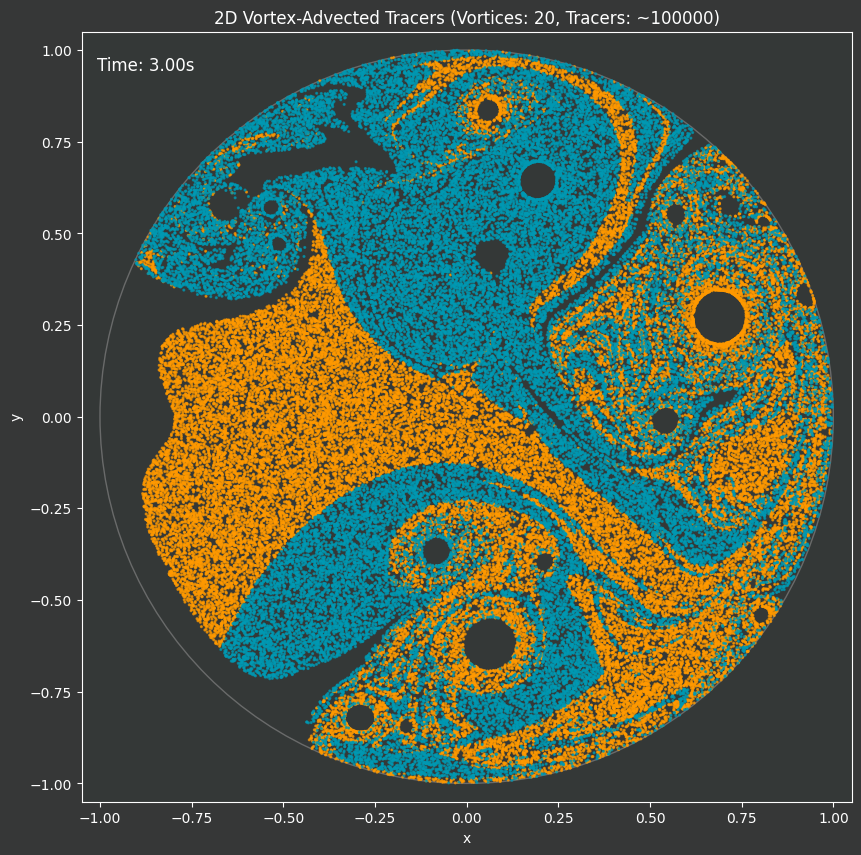

Done.


In [5]:
# Install necessary libraries:
# pip install numpy cupy-cuda11x matplotlib scipy
# (Replace cupy-cuda11x with your CUDA version, e.g., cupy-cuda12x)
# For animation saving, you might need ffmpeg:
# sudo apt-get install ffmpeg (on Linux)
# choco install ffmpeg (on Windows with Chocolatey)
# brew install ffmpeg (on macOS)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap, Normalize
import time

# Attempt to import CuPy, fallback to NumPy if not available
try:
    import cupy as cp
    GPU_ENABLED = True
    print("CuPy imported successfully. GPU acceleration is ON.")
except ImportError:
    cp = np
    GPU_ENABLED = False
    print("CuPy not found. Running on CPU with NumPy.")

# --- Configuration ---
N_VORTICES = 20 # Number of actual point vortices driving the flow
N_TRACERS = 100000 # Number of passive tracer particles for visualization

DOMAIN_RADIUS = 1.0
SIMULATION_TIME = 3.0
DT = 0.01 # Time step for RK4
OUTPUT_FILENAME = "vortex_fluid_dynamics.mp4"
PLOT_INTERVAL = 2 # Plot every N RK4 steps (more frequent for smoother tracer trails)
DPI = 150 # Animation quality

# Vortex core regularization
CORE_RADIUS_SQ = 1e-5 # Epsilon^2 for vortices
TRACER_CORE_RADIUS_SQ = 1e-7 # Smaller epsilon for tracers near vortices (can be different)

# --- Domain and Vortex/Tracer Setup ---
def initialize_vortices(num_vortices, domain_radius, xp):
    """Initializes point vortex positions and strengths."""
    positions = xp.zeros((num_vortices, 2), dtype=xp.float64)
    strengths = xp.zeros(num_vortices, dtype=xp.float64)

    # Create a few distinct clusters or patterns for interesting interaction
    if num_vortices >= 4: # Example: two dipoles
        # Dipole 1 (stronger)
        positions[0] = xp.array([-0.5, 0.2])
        strengths[0] = 2.0
        positions[1] = xp.array([-0.5, -0.2])
        strengths[1] = -2.0
        
        # Dipole 2 (weaker, offset)
        positions[2] = xp.array([0.5, 0.3])
        strengths[2] = 1.0
        positions[3] = xp.array([0.5, 0.0])
        strengths[3] = -1.0
        
        # Random for the rest
        if num_vortices > 4:
            rand_pos = xp.random.uniform(-domain_radius * 0.6, domain_radius * 0.6, (num_vortices - 4, 2))
            positions[4:] = rand_pos
            rand_strengths = xp.random.choice([-0.5, 0.5, -1.0, 1.0], num_vortices - 4) * xp.random.uniform(0.3, 0.7, num_vortices - 4)
            strengths[4:] = rand_strengths
    else: # Generic random initialization if too few for specific patterns
        positions = xp.random.uniform(-domain_radius * 0.7, domain_radius * 0.7, (num_vortices, 2))
        strengths = xp.random.choice([-1.0, 1.0], num_vortices) * xp.random.uniform(0.5, 2.0, num_vortices)

    return positions.astype(xp.float64), strengths.astype(xp.float64)

def initialize_tracers(num_tracers, domain_radius, xp):
    """Initializes passive tracer positions and assigns initial colors."""
    # Initialize tracers in two halves for distinct coloring, resembling two fluids
    tracers_per_side = num_tracers // 2
    
    positions_left = xp.random.uniform(-domain_radius * 0.95, 0, (tracers_per_side, 1)) # X for left
    positions_right = xp.random.uniform(0, domain_radius * 0.95, (num_tracers - tracers_per_side, 1)) # X for right
    
    y_left = xp.random.uniform(-domain_radius * 0.95, domain_radius * 0.95, (tracers_per_side, 1))
    y_right = xp.random.uniform(-domain_radius * 0.95, domain_radius * 0.95, (num_tracers - tracers_per_side, 1))

    tracer_pos = xp.vstack([
        xp.hstack([positions_left, y_left]),
        xp.hstack([positions_right, y_right])
    ])
    
    # Filter tracers outside the circle
    dist_sq = xp.sum(tracer_pos**2, axis=1)
    inside_mask = dist_sq < (domain_radius * 0.95)**2
    tracer_pos = tracer_pos[inside_mask]
    
    num_actual_tracers = tracer_pos.shape[0]

    # Assign colors (0 for left, 1 for right)
    tracer_colors_idx = xp.zeros(num_actual_tracers, dtype=xp.int32)
    # Re-determine based on final positions if filtering changed counts significantly
    # For simplicity, assume initial x-position determines color group
    tracer_colors_idx[tracer_pos[:,0] >= 0] = 1 
    
    return tracer_pos.astype(xp.float64), tracer_colors_idx.astype(xp.int32)


# --- Physics Calculations ---
def get_vortex_velocities(v_positions, v_strengths, domain_radius, xp):
    """Calculates the velocity of each POINT VORTEX."""
    N = v_positions.shape[0]
    velocities = xp.zeros_like(v_positions)
    
    norm_sq_all_vortices = xp.sum(v_positions**2, axis=1)
    norm_sq_all_vortices = xp.where(norm_sq_all_vortices == 0, 1e-9, norm_sq_all_vortices) 
    img_positions_all_vortices = (domain_radius**2 / norm_sq_all_vortices[:, xp.newaxis]) * v_positions

    for i in range(N):
        # Contribution from other real vortices
        diff_real = v_positions[i, :] - v_positions
        r_sq_real = xp.sum(diff_real**2, axis=1) + CORE_RADIUS_SQ
        
        mask = xp.ones(N, dtype=bool); mask[i] = False
        
        vel_x_contrib_real = -v_strengths[mask] * diff_real[mask, 1] / (2 * xp.pi * r_sq_real[mask])
        vel_y_contrib_real =  v_strengths[mask] * diff_real[mask, 0] / (2 * xp.pi * r_sq_real[mask])
        velocities[i, 0] += xp.sum(vel_x_contrib_real)
        velocities[i, 1] += xp.sum(vel_y_contrib_real)

        # Contribution from image vortices (images of OTHERS affecting current vortex i)
        for j in range(N):
            if i == j: continue
            
            pos_j_img = img_positions_all_vortices[j,:]
            strength_j_img = -v_strengths[j]
            
            diff_to_img = v_positions[i,:] - pos_j_img
            r_sq_to_img = xp.sum(diff_to_img**2) + CORE_RADIUS_SQ
            
            velocities[i,0] += -strength_j_img * diff_to_img[1] / (2 * xp.pi * r_sq_to_img)
            velocities[i,1] +=  strength_j_img * diff_to_img[0] / (2 * xp.pi * r_sq_to_img)

        # Contribution from self-image (Robin function term for vortex i)
        pos_i_norm_sq = norm_sq_all_vortices[i]
        denominator_self_img = domain_radius**2 - pos_i_norm_sq
        if xp.abs(denominator_self_img) > 1e-9:
            velocities[i,0] += -v_strengths[i] * v_positions[i,1] / (2 * xp.pi * denominator_self_img)
            velocities[i,1] +=  v_strengths[i] * v_positions[i,0] / (2 * xp.pi * denominator_self_img)
            
    return velocities

def get_tracer_velocities(t_positions, v_positions, v_strengths, domain_radius, xp):
    """Calculates velocity at TRACER locations due to point vortices and their images."""
    M = t_positions.shape[0] # Number of tracers
    N = v_positions.shape[0] # Number of vortices
    
    tracer_velocities = xp.zeros_like(t_positions)

    if N == 0: return tracer_velocities # No vortices, no flow

    # Image positions of all vortices (calculated once)
    norm_sq_all_vortices = xp.sum(v_positions**2, axis=1)
    # Avoid division by zero if a vortex is at the origin
    norm_sq_all_vortices = xp.where(norm_sq_all_vortices == 0, 1e-9, norm_sq_all_vortices) 
    img_v_positions = (domain_radius**2 / norm_sq_all_vortices[:, xp.newaxis]) * v_positions
    img_v_strengths = -v_strengths

    # Expand tracer positions and vortex positions for broadcasting
    # t_pos_exp = t_positions[:, xp.newaxis, :]  # M x 1 x 2
    # v_pos_exp = v_positions[xp.newaxis, :, :]  # 1 x N x 2
    # img_v_pos_exp = img_v_positions[xp.newaxis, :, :] # 1 x N x 2
    
    # Velocity due to real vortices
    # diff_real = t_pos_exp - v_pos_exp  # M x N x 2
    # r_sq_real = xp.sum(diff_real**2, axis=2) + TRACER_CORE_RADIUS_SQ # M x N
    # inv_r_sq_real = 1.0 / (2 * xp.pi * r_sq_real) # M x N
    
    # vel_x_real = -v_strengths[xp.newaxis, :] * diff_real[:, :, 1] * inv_r_sq_real # M x N
    # vel_y_real =  v_strengths[xp.newaxis, :] * diff_real[:, :, 0] * inv_r_sq_real # M x N
    
    # tracer_velocities[:, 0] += xp.sum(vel_x_real, axis=1) # Sum over N vortices
    # tracer_velocities[:, 1] += xp.sum(vel_y_real, axis=1)

    # Velocity due to image vortices
    # diff_img = t_pos_exp - img_v_pos_exp # M x N x 2
    # r_sq_img = xp.sum(diff_img**2, axis=2) + TRACER_CORE_RADIUS_SQ # M x N
    # inv_r_sq_img = 1.0 / (2 * xp.pi * r_sq_img) # M x N

    # vel_x_img = -img_v_strengths[xp.newaxis, :] * diff_img[:, :, 1] * inv_r_sq_img # M x N
    # vel_y_img =  img_v_strengths[xp.newaxis, :] * diff_img[:, :, 0] * inv_r_sq_img # M x N
    
    # tracer_velocities[:, 0] += xp.sum(vel_x_img, axis=1)
    # tracer_velocities[:, 1] += xp.sum(vel_y_img, axis=1)

    # Looping for M tracers if N is small, or use full broadcast if memory allows
    # For M=20000, N=20, full broadcast is (20000,20,2) which is feasible.
    # Let's implement the loop approach for clarity and potentially better memory for very large M
    for k_vortex in range(N):
        # Real vortex k_vortex
        diff_real = t_positions - v_positions[k_vortex, :] # M x 2
        r_sq_real = xp.sum(diff_real**2, axis=1) + TRACER_CORE_RADIUS_SQ # M
        inv_r_sq_real = v_strengths[k_vortex] / (2 * xp.pi * r_sq_real) # M
        
        tracer_velocities[:, 0] += -diff_real[:, 1] * inv_r_sq_real
        tracer_velocities[:, 1] +=  diff_real[:, 0] * inv_r_sq_real
        
        # Image of vortex k_vortex
        diff_img = t_positions - img_v_positions[k_vortex, :] # M x 2
        r_sq_img = xp.sum(diff_img**2, axis=1) + TRACER_CORE_RADIUS_SQ # M
        inv_r_sq_img = img_v_strengths[k_vortex] / (2 * xp.pi * r_sq_img) # M
        
        tracer_velocities[:, 0] += -diff_img[:, 1] * inv_r_sq_img
        tracer_velocities[:, 1] +=  diff_img[:, 0] * inv_r_sq_img
        
    return tracer_velocities

# --- ODE Solver (RK4) for System ---
def rk4_step_system(v_pos, t_pos, v_str, domain_radius, dt, xp):
    # K1
    k1_v = get_vortex_velocities(v_pos, v_str, domain_radius, xp)
    k1_t = get_tracer_velocities(t_pos, v_pos, v_str, domain_radius, xp)
    
    # K2
    k2_v = get_vortex_velocities(v_pos + 0.5 * dt * k1_v, v_str, domain_radius, xp)
    k2_t = get_tracer_velocities(t_pos + 0.5 * dt * k1_t, 
                                 v_pos + 0.5 * dt * k1_v, v_str, domain_radius, xp)
    
    # K3
    k3_v = get_vortex_velocities(v_pos + 0.5 * dt * k2_v, v_str, domain_radius, xp)
    k3_t = get_tracer_velocities(t_pos + 0.5 * dt * k2_t,
                                 v_pos + 0.5 * dt * k2_v, v_str, domain_radius, xp)
    
    # K4
    k4_v = get_vortex_velocities(v_pos + dt * k3_v, v_str, domain_radius, xp)
    k4_t = get_tracer_velocities(t_pos + dt * k3_t,
                                 v_pos + dt * k3_v, v_str, domain_radius, xp)
    
    new_v_pos = v_pos + (dt / 6.0) * (k1_v + 2*k2_v + 2*k3_v + k4_v)
    new_t_pos = t_pos + (dt / 6.0) * (k1_t + 2*k2_t + 2*k3_t + k4_t)
    
    return new_v_pos, new_t_pos

# --- Simulation Runner ---
def run_simulation(xp):
    vortex_pos, vortex_strengths = initialize_vortices(N_VORTICES, DOMAIN_RADIUS, xp)
    tracer_pos, tracer_colors_idx = initialize_tracers(N_TRACERS, DOMAIN_RADIUS, xp)
    
    num_steps = int(SIMULATION_TIME / DT)
    num_plot_steps = int(SIMULATION_TIME / (DT * PLOT_INTERVAL)) + 1
    
    # Store history only for tracers for animation, vortices can be plotted if desired too
    tracer_history = xp.zeros((num_plot_steps, tracer_pos.shape[0], 2), dtype=xp.float32) 
    # vortex_history = xp.zeros((num_plot_steps, N_VORTICES, 2), dtype=xp.float32)
    times = xp.zeros(num_plot_steps, dtype=xp.float32)
    
    tracer_history[0] = tracer_pos.copy()
    # vortex_history[0] = vortex_pos.copy()
    times[0] = 0.0
    
    current_time = 0.0
    plot_idx = 1
    
    start_sim_time = time.time()
    for step in range(1, num_steps + 1):
        vortex_pos, tracer_pos = rk4_step_system(vortex_pos, tracer_pos, vortex_strengths, 
                                                 DOMAIN_RADIUS, DT, xp)
        current_time += DT
        
        # Boundary check for vortices (crude reflection)
        dist_sq_v = xp.sum(vortex_pos**2, axis=1)
        escaped_v = dist_sq_v >= DOMAIN_RADIUS**2
        if xp.any(escaped_v):
            vortex_pos[escaped_v] *= (DOMAIN_RADIUS * 0.999 / xp.sqrt(dist_sq_v[escaped_v, xp.newaxis]))

        # Boundary check for tracers (remove them if they escape)
        # This is simpler than reflecting many tracers and can look like fluid dissipating
        dist_sq_t = xp.sum(tracer_pos**2, axis=1)
        keep_mask_t = dist_sq_t < DOMAIN_RADIUS**2
        tracer_pos = tracer_pos[keep_mask_t, :]
        tracer_colors_idx = tracer_colors_idx[keep_mask_t] # Important: Keep colors consistent

        if tracer_pos.shape[0] == 0:
            print("All tracers escaped or dissipated!")
            break

        if step % PLOT_INTERVAL == 0 and plot_idx < num_plot_steps:
            # Need to handle variable number of tracers if they are removed
            # For fixed-size history, we can pad or just accept fewer tracers over time
            # A simpler way for animation: just store current state for current frame.
            # The current animate function expects full history. Let's adapt run_simulation
            # to store lists of arrays if tracer count changes, or preallocate and fill.
            # For now, let's assume fixed tracer_history size and fill what we can.
            # This will lead to empty spots if tracers are removed.
            # A better way: store a list of tracer arrays.
            if plot_idx == 1: # Re-init history if tracer count changed drastically on first step
                 tracer_history = xp.zeros((num_plot_steps, tracer_pos.shape[0], 2), dtype=xp.float32)
                 tracer_history[0] = tracer_pos.copy() # Update with current tracer_pos

            if tracer_pos.shape[0] == tracer_history.shape[1]: # if count hasn't changed
                tracer_history[plot_idx] = tracer_pos.copy()
            # else:
                # print(f"Tracer count changed from {tracer_history.shape[1]} to {tracer_pos.shape[0]}. Animation might be affected.")
                # Could implement a more robust history storage here for variable tracer counts.
            
            # vortex_history[plot_idx] = vortex_pos.copy()
            times[plot_idx] = current_time
            plot_idx += 1
        
        if step % (num_steps // 20) == 0 or step == num_steps : # Print progress ~20 times
            print(f"Step {step}/{num_steps}, Time: {current_time:.2f}s, Tracers: {tracer_pos.shape[0]}")
            
    end_sim_time = time.time()
    print(f"Simulation finished in {end_sim_time - start_sim_time:.2f} seconds.")
    
    # Trim history if simulation ended early or fewer plot steps taken
    tracer_history = tracer_history[:plot_idx]
    # vortex_history = vortex_history[:plot_idx]
    times = times[:plot_idx]

    if GPU_ENABLED:
        tracer_history = cp.asnumpy(tracer_history)
        # vortex_history = cp.asnumpy(vortex_history)
        times = cp.asnumpy(times)
        vortex_strengths = cp.asnumpy(vortex_strengths)
        tracer_colors_idx = cp.asnumpy(tracer_colors_idx) # Initial colors needed for consistent coloring
                                                        # If tracers are removed, this needs careful handling for animation
                                                        # For now, pass the INITIAL tracer_colors_idx and hope animator handles subset
                                                        # This is not ideal. We need colors for the tracers *at each frame*.
                                                        # Let's re-think tracer_colors_idx for animation.
                                                        # It should be tied to the tracers in tracer_history.
                                                        # The current setup passes the initial tracer_colors_idx from initialize_tracers.
                                                        # This is only correct if no tracers are removed.
                                                        # If tracers are removed, we need a list of color index arrays.
                                                        # For simplicity NOW, we'll use the initial tracer_colors_idx and assume matplotlib scatter
                                                        # will only color the points it's given offsets for.
                                                        # The *initial* full set of tracer_color_idx is used.

    # Get the tracer_colors_idx that corresponds to the *initial* set of tracers that were tracked for the *first* frame.
    # This is a simplification due to the potential removal of tracers.
    # A more robust solution would store (tracer_pos_frame, tracer_color_idx_frame) tuples.
    _, initial_tracer_colors_for_animation = initialize_tracers(N_TRACERS, DOMAIN_RADIUS, np) # Use np for consistency in animate

    return tracer_history, times, vortex_strengths, initial_tracer_colors_for_animation[:tracer_history.shape[1]]


# --- Plotting and Animation ---
def animate(tracer_hist, times_np, v_strengths_np, tracer_cols_idx_np):
    fig, ax = plt.subplots(figsize=(10, 10), facecolor='xkcd:dark grey') # Dark background
    ax.set_facecolor('xkcd:charcoal')
    ax.set_aspect('equal')
    ax.set_xlim(-DOMAIN_RADIUS * 1.05, DOMAIN_RADIUS * 1.05)
    ax.set_ylim(-DOMAIN_RADIUS * 1.05, DOMAIN_RADIUS * 1.05)
    ax.set_title(f"2D Vortex-Advected Tracers (Vortices: {N_VORTICES}, Tracers: ~{N_TRACERS})", color='white')
    ax.set_xlabel("x", color='white')
    ax.set_ylabel("y", color='white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white') 
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')


    # Draw domain boundary
    domain_circle = plt.Circle((0, 0), DOMAIN_RADIUS, color='gray', fill=False, ls='-', lw=1.0, alpha=0.7)
    ax.add_artist(domain_circle)

    # Define colormap for tracers (e.g., orange and blue)
    # Or more psychedelic: plt.cm.viridis, plt.cm.plasma, plt.cm.magma
    # Let's try orange/blue from the first image
    #cmap_tracers = ListedColormap(['#FF8C00', '#1E90FF']) # DarkOrange, DodgerBlue
    # For more fluid-like, try 'ocean' or 'terrain' like variations.
    # The example image has bright, saturated, almost emissive colors.
    # Let's use 'cool' and 'autumn' as distinct tracer sets for now for a "hot/cold" fluid look
    colors_for_tracers = [plt.cm.autumn(0.6), plt.cm.winter(0.6)] # Mid-range of autumn (red-orange-yellow) and winter (blue-cyan)
    cmap_tracers = ListedColormap(colors_for_tracers)


    # Scatter plot for tracers
    # Smaller points, slight alpha for density effect
    # The color of each point is determined by tracer_cols_idx_np
    # Ensure tracer_cols_idx_np has the right length for the *first frame* of tracer_hist
    
    # Check if tracer_hist is empty
    if tracer_hist.shape[0] == 0 or tracer_hist.shape[1] == 0:
        print("No tracer history to animate.")
        return

    num_tracers_in_history = tracer_hist.shape[1]
    
    # Select colors for the tracers present in the history
    # This assumes tracer_cols_idx_np corresponds to the *initial* set of tracers
    # and its length matches num_tracers_in_history
    if len(tracer_cols_idx_np) != num_tracers_in_history:
         print(f"Warning: Mismatch in tracer color indices ({len(tracer_cols_idx_np)}) and tracers in history ({num_tracers_in_history}). Using subset of colors.")
         # This is a fallback. Ideally, color indices should be managed per frame if tracers are removed.
         current_tracer_colors = cmap_tracers(tracer_cols_idx_np[:num_tracers_in_history] % cmap_tracers.N)
    else:
         current_tracer_colors = cmap_tracers(tracer_cols_idx_np % cmap_tracers.N)


    scatter = ax.scatter([], [], s=1.5, marker='o', edgecolors='none', alpha=0.7)

    # Vortices (optional, can be plotted small or not at all)
    # cmap_vortex = plt.cm.coolwarm
    # norm_vortex = Normalize(vmin=np.min(v_strengths_np) if v_strengths_np.size > 0 else -1, 
    #                         vmax=np.max(v_strengths_np) if v_strengths_np.size > 0 else 1)
    # vortex_colors_mapped = cmap_vortex(norm_vortex(v_strengths_np))
    # vortex_scatter = ax.scatter([], [], s=20, edgecolors='k', linewidths=0.5, zorder=10)

    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, color='white', fontsize=12)

    def update(frame):
        positions_at_frame = tracer_hist[frame]
        
        # If tracers were removed, positions_at_frame might be shorter than initial
        # The scatter plot should handle this by only plotting available points.
        # However, the colors need to match. This is the tricky part with tracer removal.
        # For now, we assume current_tracer_colors (derived from initial) is sufficient.
        scatter.set_offsets(positions_at_frame)
        scatter.set_color(current_tracer_colors[:len(positions_at_frame)]) # Color only existing tracers

        # if frame < vortex_hist.shape[0]: # Check if vortex_hist has this frame
        #     vortex_scatter.set_offsets(vortex_hist[frame])
        #     vortex_scatter.set_color(vortex_colors_mapped)
        
        time_text.set_text(f"Time: {times_np[frame]:.2f}s")
        if frame % 20 == 0: print(f"Animating frame {frame+1}/{len(tracer_hist)}") # Progress
        # return [scatter, vortex_scatter, time_text]
        return [scatter, time_text]


    ani = animation.FuncAnimation(fig, update, frames=len(tracer_hist), interval=33, blit=True) # 30 fps approx
    
    print(f"Saving animation to {OUTPUT_FILENAME} (this may take a while)...")
    start_save_time = time.time()
    ani.save(OUTPUT_FILENAME, writer='ffmpeg', fps=30, dpi=DPI,savefig_kwargs={'facecolor': fig.get_facecolor()})
    end_save_time = time.time()
    print(f"Animation saved in {end_save_time - start_save_time:.2f} seconds.")
    plt.show()


# --- Main Execution ---
if __name__ == "__main__":
    selected_xp = cp if GPU_ENABLED else np
    
    print("Starting simulation with tracers...")
    # Unpack all returned values
    tr_history, sim_times, v_strengths, tr_colors_initial = run_simulation(selected_xp)
    
    if tr_history.shape[0] > 1: # Check if there's more than the initial frame
        print("Starting animation...")
        animate(tr_history, sim_times, v_strengths, tr_colors_initial)
    else:
        print("Simulation too short or no tracers left to animate.")

    print("Done.")